In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle


from tensorflow.keras.layers import MultiHeadAttention,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate
from tensorflow.keras import callbacks 

from sklearn.model_selection import KFold

In [2]:
#retrieve data
num = 2000 # number of profiles
nvza = 2 # number of channels
nsza=1



In [3]:
# spatial slicing dimensions
s = 82 # output slice size
ts = 82 # input slice size 32


In [7]:
#get the averaged reflectance from the dataset 
r=np.load('monte_carlo_r.npy')
print(r.shape)
r=r.reshape((2000, 82, 2))
print(r.shape)

(2000, 82, 1, 2)
(2000, 82, 2)


In [8]:
#get the averaged reflectance from the dataset 
c=np.load('monte_carlo_cot.npy')
c.shape

(2000, 82)

In [9]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')


train_size: 1600 profiles
test_size: 400 profiles


In [10]:
import os
checkpoint_path = "training_random_bilstm_transformer/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [14]:

def eval_model(train_image, test_image, train_label, test_label):

    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()

    bsize = 16
    eps = 4000

    #bi-LSTM
    input_layer = tf.keras.layers.Input(shape=(ts,2),name='Input')
    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True,input_shape=(ts,2)))(input_layer) 
    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True))(bi)


    #transformer block 
    slf_attn = MultiHeadAttention(num_heads=3,key_dim=3)(bi,bi) ####understand the key_dim and num_heads
    layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(slf_attn+bi)
    dense1=tf.keras.layers.Dense(128,activation='relu')(layernorm1)
    layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(layernorm1+dense1)
    
    flat=tf.keras.layers.Flatten()(layernorm2)
    #pooling
    #avg_pool = GlobalAveragePooling1D()(layernorm2)
    #max_pool = GlobalMaxPooling1D()(layernorm2)
    #conc = concatenate([avg_pool, max_pool])

    #dense
   # dense2 = tf.keras.layers.Dense(256,activation='relu')(conc)
    drop=tf.keras.layers.Dropout(0.2)(flat)
    output = tf.keras.layers.Dense(82,activation='relu')(drop)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',loss=['mse'],metrics=[ltype,type2])
    model.summary()

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping,cp_callback])

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    results
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]
    
    return model,rmse,mse,history,predictions

In [15]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,1600,ts,2)) #train: 400*4  test:400
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,ts,2))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index] #r: radiance dataset
    y_train[count], y_test[count] = c[train_index], c[test_index] #c: cot dataset(label)
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 400  401  402 ... 1997 1998 1999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [16]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 82, 2)]      0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 82, 128)      34304       Input[0][0]                      
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 82, 128)      98816       bidirectional_2[0][0]            
__________________________________________________________________________________________________
multi_head_attention_1 (MultiHe (None, 82, 128)      4763        bidirectional_3[0][0]            
                                                                 bidirectional_3[0][0]        

75/75 [==============================] - 2s 23ms/step - loss: 2.9041 - mean_squared_error: 2.9041 - root_mean_squared_error: 1.7040 - val_loss: 3.3290 - val_mean_squared_error: 3.3290 - val_root_mean_squared_error: 1.8246

Epoch 00017: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 18/4000
75/75 [==============================] - 2s 24ms/step - loss: 2.7952 - mean_squared_error: 2.7952 - root_mean_squared_error: 1.6718 - val_loss: 3.2267 - val_mean_squared_error: 3.2267 - val_root_mean_squared_error: 1.7963

Epoch 00018: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 19/4000
75/75 [==============================] - 2s 24ms/step - loss: 2.6577 - mean_squared_error: 2.6577 - root_mean_squared_error: 1.6301 - val_loss: 3.2258 - val_mean_squared_error: 3.2258 - val_root_mean_squared_error: 1.7961

Epoch 00019: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 20/4000
75/75 [==============================] - 2s 23ms/step - loss: 2.5794 - me


Epoch 00043: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 44/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.4225 - mean_squared_error: 1.4225 - root_mean_squared_error: 1.1927 - val_loss: 2.5917 - val_mean_squared_error: 2.5917 - val_root_mean_squared_error: 1.6099

Epoch 00044: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 45/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.4318 - mean_squared_error: 1.4318 - root_mean_squared_error: 1.1965 - val_loss: 2.5678 - val_mean_squared_error: 2.5678 - val_root_mean_squared_error: 1.6024

Epoch 00045: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 46/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.3930 - mean_squared_error: 1.3930 - root_mean_squared_error: 1.1802 - val_loss: 2.4899 - val_mean_squared_error: 2.4899 - val_root_mean_squared_error: 1.5779

Epoch 00046: saving model to training_random_bilstm_transformer\cp.ckpt


75/75 [==============================] - 2s 23ms/step - loss: 0.9858 - mean_squared_error: 0.9858 - root_mean_squared_error: 0.9928 - val_loss: 2.4061 - val_mean_squared_error: 2.4061 - val_root_mean_squared_error: 1.5512

Epoch 00070: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 71/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.9983 - mean_squared_error: 0.9983 - root_mean_squared_error: 0.9990 - val_loss: 2.5409 - val_mean_squared_error: 2.5409 - val_root_mean_squared_error: 1.5940

Epoch 00071: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 72/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.0263 - mean_squared_error: 1.0263 - root_mean_squared_error: 1.0130 - val_loss: 2.4894 - val_mean_squared_error: 2.4894 - val_root_mean_squared_error: 1.5778

Epoch 00072: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 73/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.0350 - me

75/75 [==============================] - 2s 23ms/step - loss: 0.8069 - mean_squared_error: 0.8069 - root_mean_squared_error: 0.8982 - val_loss: 2.3342 - val_mean_squared_error: 2.3342 - val_root_mean_squared_error: 1.5278

Epoch 00096: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 97/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.8666 - mean_squared_error: 0.8666 - root_mean_squared_error: 0.9309 - val_loss: 2.2503 - val_mean_squared_error: 2.2503 - val_root_mean_squared_error: 1.5001

Epoch 00097: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 98/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.8011 - mean_squared_error: 0.8011 - root_mean_squared_error: 0.8950 - val_loss: 2.2596 - val_mean_squared_error: 2.2596 - val_root_mean_squared_error: 1.5032

Epoch 00098: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 99/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.8108 - me


Epoch 00122: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 123/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.7007 - mean_squared_error: 0.7007 - root_mean_squared_error: 0.8371 - val_loss: 2.1031 - val_mean_squared_error: 2.1031 - val_root_mean_squared_error: 1.4502

Epoch 00123: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 124/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6877 - mean_squared_error: 0.6877 - root_mean_squared_error: 0.8292 - val_loss: 2.1189 - val_mean_squared_error: 2.1189 - val_root_mean_squared_error: 1.4556

Epoch 00124: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 125/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6836 - mean_squared_error: 0.6836 - root_mean_squared_error: 0.8268 - val_loss: 2.1960 - val_mean_squared_error: 2.1960 - val_root_mean_squared_error: 1.4819

Epoch 00125: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.6127 - mean_squared_error: 0.6127 - root_mean_squared_error: 0.7827 - val_loss: 2.0279 - val_mean_squared_error: 2.0279 - val_root_mean_squared_error: 1.4240

Epoch 00149: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 150/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6076 - mean_squared_error: 0.6076 - root_mean_squared_error: 0.7794 - val_loss: 2.0403 - val_mean_squared_error: 2.0403 - val_root_mean_squared_error: 1.4284

Epoch 00150: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 151/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6050 - mean_squared_error: 0.6050 - root_mean_squared_error: 0.7778 - val_loss: 2.0315 - val_mean_squared_error: 2.0315 - val_root_mean_squared_error: 1.4253

Epoch 00151: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 152/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6215 -


Epoch 00175: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 176/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5641 - mean_squared_error: 0.5641 - root_mean_squared_error: 0.7511 - val_loss: 1.9288 - val_mean_squared_error: 1.9288 - val_root_mean_squared_error: 1.3888

Epoch 00176: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 177/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5578 - mean_squared_error: 0.5578 - root_mean_squared_error: 0.7468 - val_loss: 1.9256 - val_mean_squared_error: 1.9256 - val_root_mean_squared_error: 1.3876

Epoch 00177: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 178/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5591 - mean_squared_error: 0.5591 - root_mean_squared_error: 0.7477 - val_loss: 1.9489 - val_mean_squared_error: 1.9489 - val_root_mean_squared_error: 1.3960

Epoch 00178: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.5311 - mean_squared_error: 0.5311 - root_mean_squared_error: 0.7287 - val_loss: 1.8738 - val_mean_squared_error: 1.8738 - val_root_mean_squared_error: 1.3689

Epoch 00202: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 203/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5364 - mean_squared_error: 0.5364 - root_mean_squared_error: 0.7323 - val_loss: 1.9148 - val_mean_squared_error: 1.9148 - val_root_mean_squared_error: 1.3838

Epoch 00203: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 204/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5327 - mean_squared_error: 0.5327 - root_mean_squared_error: 0.7298 - val_loss: 1.8950 - val_mean_squared_error: 1.8950 - val_root_mean_squared_error: 1.3766

Epoch 00204: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 205/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5325 -


Epoch 00228: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 229/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5110 - mean_squared_error: 0.5110 - root_mean_squared_error: 0.7148 - val_loss: 1.8063 - val_mean_squared_error: 1.8063 - val_root_mean_squared_error: 1.3440

Epoch 00229: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 230/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4907 - mean_squared_error: 0.4907 - root_mean_squared_error: 0.7004 - val_loss: 1.8385 - val_mean_squared_error: 1.8385 - val_root_mean_squared_error: 1.3559

Epoch 00230: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 231/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5000 - mean_squared_error: 0.5000 - root_mean_squared_error: 0.7071 - val_loss: 1.8397 - val_mean_squared_error: 1.8397 - val_root_mean_squared_error: 1.3564

Epoch 00231: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.4533 - mean_squared_error: 0.4533 - root_mean_squared_error: 0.6732 - val_loss: 1.7396 - val_mean_squared_error: 1.7396 - val_root_mean_squared_error: 1.3189

Epoch 00255: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 256/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4517 - mean_squared_error: 0.4517 - root_mean_squared_error: 0.6720 - val_loss: 1.7456 - val_mean_squared_error: 1.7456 - val_root_mean_squared_error: 1.3212

Epoch 00256: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 257/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4804 - mean_squared_error: 0.4804 - root_mean_squared_error: 0.6931 - val_loss: 1.7374 - val_mean_squared_error: 1.7374 - val_root_mean_squared_error: 1.3181

Epoch 00257: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 258/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4594 -

75/75 [==============================] - 2s 23ms/step - loss: 0.4320 - mean_squared_error: 0.4320 - root_mean_squared_error: 0.6573 - val_loss: 1.6967 - val_mean_squared_error: 1.6967 - val_root_mean_squared_error: 1.3026

Epoch 00281: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 282/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4476 - mean_squared_error: 0.4476 - root_mean_squared_error: 0.6690 - val_loss: 1.6975 - val_mean_squared_error: 1.6975 - val_root_mean_squared_error: 1.3029

Epoch 00282: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 283/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4445 - mean_squared_error: 0.4445 - root_mean_squared_error: 0.6667 - val_loss: 1.7078 - val_mean_squared_error: 1.7078 - val_root_mean_squared_error: 1.3068

Epoch 00283: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 284/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4498 -


Epoch 00307: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 308/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4280 - mean_squared_error: 0.4280 - root_mean_squared_error: 0.6542 - val_loss: 1.6778 - val_mean_squared_error: 1.6778 - val_root_mean_squared_error: 1.2953

Epoch 00308: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 309/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4296 - mean_squared_error: 0.4296 - root_mean_squared_error: 0.6554 - val_loss: 1.6736 - val_mean_squared_error: 1.6736 - val_root_mean_squared_error: 1.2937

Epoch 00309: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 310/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4322 - mean_squared_error: 0.4322 - root_mean_squared_error: 0.6574 - val_loss: 1.6816 - val_mean_squared_error: 1.6816 - val_root_mean_squared_error: 1.2968

Epoch 00310: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.4212 - mean_squared_error: 0.4212 - root_mean_squared_error: 0.6490 - val_loss: 1.6159 - val_mean_squared_error: 1.6159 - val_root_mean_squared_error: 1.2712

Epoch 00334: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 335/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4037 - mean_squared_error: 0.4037 - root_mean_squared_error: 0.6354 - val_loss: 1.6150 - val_mean_squared_error: 1.6150 - val_root_mean_squared_error: 1.2708

Epoch 00335: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 336/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4081 - mean_squared_error: 0.4081 - root_mean_squared_error: 0.6388 - val_loss: 1.6041 - val_mean_squared_error: 1.6041 - val_root_mean_squared_error: 1.2665

Epoch 00336: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 337/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4042 -


Epoch 00360: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 361/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4026 - mean_squared_error: 0.4026 - root_mean_squared_error: 0.6345 - val_loss: 1.5876 - val_mean_squared_error: 1.5876 - val_root_mean_squared_error: 1.2600

Epoch 00361: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 362/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4038 - mean_squared_error: 0.4038 - root_mean_squared_error: 0.6354 - val_loss: 1.6219 - val_mean_squared_error: 1.6219 - val_root_mean_squared_error: 1.2736

Epoch 00362: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 363/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4022 - mean_squared_error: 0.4022 - root_mean_squared_error: 0.6341 - val_loss: 1.5996 - val_mean_squared_error: 1.5996 - val_root_mean_squared_error: 1.2648

Epoch 00363: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3910 - mean_squared_error: 0.3910 - root_mean_squared_error: 0.6253 - val_loss: 1.5371 - val_mean_squared_error: 1.5371 - val_root_mean_squared_error: 1.2398

Epoch 00387: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 388/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3939 - mean_squared_error: 0.3939 - root_mean_squared_error: 0.6276 - val_loss: 1.5524 - val_mean_squared_error: 1.5524 - val_root_mean_squared_error: 1.2459

Epoch 00388: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 389/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3918 - mean_squared_error: 0.3918 - root_mean_squared_error: 0.6259 - val_loss: 1.5429 - val_mean_squared_error: 1.5429 - val_root_mean_squared_error: 1.2421

Epoch 00389: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 390/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3981 -


Epoch 00413: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 414/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3725 - mean_squared_error: 0.3725 - root_mean_squared_error: 0.6103 - val_loss: 1.5295 - val_mean_squared_error: 1.5295 - val_root_mean_squared_error: 1.2367

Epoch 00414: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 415/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3711 - mean_squared_error: 0.3711 - root_mean_squared_error: 0.6091 - val_loss: 1.5060 - val_mean_squared_error: 1.5060 - val_root_mean_squared_error: 1.2272

Epoch 00415: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 416/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3750 - mean_squared_error: 0.3750 - root_mean_squared_error: 0.6123 - val_loss: 1.5388 - val_mean_squared_error: 1.5388 - val_root_mean_squared_error: 1.2405

Epoch 00416: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3804 - mean_squared_error: 0.3804 - root_mean_squared_error: 0.6167 - val_loss: 1.4943 - val_mean_squared_error: 1.4943 - val_root_mean_squared_error: 1.2224

Epoch 00440: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 441/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3640 - mean_squared_error: 0.3640 - root_mean_squared_error: 0.6033 - val_loss: 1.4787 - val_mean_squared_error: 1.4787 - val_root_mean_squared_error: 1.2160

Epoch 00441: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 442/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3623 - mean_squared_error: 0.3623 - root_mean_squared_error: 0.6019 - val_loss: 1.4730 - val_mean_squared_error: 1.4730 - val_root_mean_squared_error: 1.2137

Epoch 00442: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 443/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3710 -


Epoch 00466: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 467/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.3627 - mean_squared_error: 0.3627 - root_mean_squared_error: 0.6022 - val_loss: 1.4465 - val_mean_squared_error: 1.4465 - val_root_mean_squared_error: 1.2027

Epoch 00467: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 468/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.3685 - mean_squared_error: 0.3685 - root_mean_squared_error: 0.6070 - val_loss: 1.4383 - val_mean_squared_error: 1.4383 - val_root_mean_squared_error: 1.1993

Epoch 00468: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 469/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.3695 - mean_squared_error: 0.3695 - root_mean_squared_error: 0.6079 - val_loss: 1.4647 - val_mean_squared_error: 1.4647 - val_root_mean_squared_error: 1.2102

Epoch 00469: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 25ms/step - loss: 0.3675 - mean_squared_error: 0.3675 - root_mean_squared_error: 0.6062 - val_loss: 1.4139 - val_mean_squared_error: 1.4139 - val_root_mean_squared_error: 1.1891

Epoch 00493: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 494/4000
75/75 [==============================] - 2s 26ms/step - loss: 0.3551 - mean_squared_error: 0.3551 - root_mean_squared_error: 0.5957 - val_loss: 1.4164 - val_mean_squared_error: 1.4164 - val_root_mean_squared_error: 1.1901

Epoch 00494: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 495/4000
75/75 [==============================] - 2s 26ms/step - loss: 0.3480 - mean_squared_error: 0.3480 - root_mean_squared_error: 0.5899 - val_loss: 1.4115 - val_mean_squared_error: 1.4115 - val_root_mean_squared_error: 1.1881

Epoch 00495: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 496/4000
75/75 [==============================] - 2s 26ms/step - loss: 0.3493 -

75/75 [==============================] - 2s 27ms/step - loss: 0.3505 - mean_squared_error: 0.3505 - root_mean_squared_error: 0.5920 - val_loss: 1.3925 - val_mean_squared_error: 1.3925 - val_root_mean_squared_error: 1.1800

Epoch 00519: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 520/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3540 - mean_squared_error: 0.3540 - root_mean_squared_error: 0.5949 - val_loss: 1.4033 - val_mean_squared_error: 1.4033 - val_root_mean_squared_error: 1.1846

Epoch 00520: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 521/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3564 - mean_squared_error: 0.3564 - root_mean_squared_error: 0.5970 - val_loss: 1.3806 - val_mean_squared_error: 1.3806 - val_root_mean_squared_error: 1.1750

Epoch 00521: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 522/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3487 -


Epoch 00545: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 546/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3393 - mean_squared_error: 0.3393 - root_mean_squared_error: 0.5825 - val_loss: 1.3761 - val_mean_squared_error: 1.3761 - val_root_mean_squared_error: 1.1731

Epoch 00546: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 547/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3243 - mean_squared_error: 0.3243 - root_mean_squared_error: 0.5694 - val_loss: 1.3821 - val_mean_squared_error: 1.3821 - val_root_mean_squared_error: 1.1756

Epoch 00547: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 548/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3575 - mean_squared_error: 0.3575 - root_mean_squared_error: 0.5979 - val_loss: 1.3901 - val_mean_squared_error: 1.3901 - val_root_mean_squared_error: 1.1790

Epoch 00548: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3301 - mean_squared_error: 0.3301 - root_mean_squared_error: 0.5745 - val_loss: 1.3660 - val_mean_squared_error: 1.3660 - val_root_mean_squared_error: 1.1688

Epoch 00572: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 573/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3486 - mean_squared_error: 0.3486 - root_mean_squared_error: 0.5904 - val_loss: 1.3574 - val_mean_squared_error: 1.3574 - val_root_mean_squared_error: 1.1651

Epoch 00573: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 574/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3336 - mean_squared_error: 0.3336 - root_mean_squared_error: 0.5775 - val_loss: 1.3505 - val_mean_squared_error: 1.3505 - val_root_mean_squared_error: 1.1621

Epoch 00574: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 575/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3349 -


Epoch 00598: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 599/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3351 - mean_squared_error: 0.3351 - root_mean_squared_error: 0.5789 - val_loss: 1.3138 - val_mean_squared_error: 1.3138 - val_root_mean_squared_error: 1.1462

Epoch 00599: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 600/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3267 - mean_squared_error: 0.3267 - root_mean_squared_error: 0.5715 - val_loss: 1.3338 - val_mean_squared_error: 1.3338 - val_root_mean_squared_error: 1.1549

Epoch 00600: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 601/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3282 - mean_squared_error: 0.3282 - root_mean_squared_error: 0.5728 - val_loss: 1.3144 - val_mean_squared_error: 1.3144 - val_root_mean_squared_error: 1.1465

Epoch 00601: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3224 - mean_squared_error: 0.3224 - root_mean_squared_error: 0.5678 - val_loss: 1.2958 - val_mean_squared_error: 1.2958 - val_root_mean_squared_error: 1.1383

Epoch 00625: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 626/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3149 - mean_squared_error: 0.3149 - root_mean_squared_error: 0.5611 - val_loss: 1.3007 - val_mean_squared_error: 1.3007 - val_root_mean_squared_error: 1.1405

Epoch 00626: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 627/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3305 - mean_squared_error: 0.3305 - root_mean_squared_error: 0.5749 - val_loss: 1.3266 - val_mean_squared_error: 1.3266 - val_root_mean_squared_error: 1.1518

Epoch 00627: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 628/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3351 -

75/75 [==============================] - 2s 23ms/step - loss: 0.3169 - mean_squared_error: 0.3169 - root_mean_squared_error: 0.5629 - val_loss: 1.2685 - val_mean_squared_error: 1.2685 - val_root_mean_squared_error: 1.1263

Epoch 00651: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 652/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3167 - mean_squared_error: 0.3167 - root_mean_squared_error: 0.5628 - val_loss: 1.2804 - val_mean_squared_error: 1.2804 - val_root_mean_squared_error: 1.1315

Epoch 00652: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 653/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3236 - mean_squared_error: 0.3236 - root_mean_squared_error: 0.5688 - val_loss: 1.2787 - val_mean_squared_error: 1.2787 - val_root_mean_squared_error: 1.1308

Epoch 00653: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 654/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3203 -


Epoch 00677: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 678/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.3299 - mean_squared_error: 0.3299 - root_mean_squared_error: 0.5744 - val_loss: 1.3039 - val_mean_squared_error: 1.3039 - val_root_mean_squared_error: 1.1419

Epoch 00678: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 679/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3196 - mean_squared_error: 0.3196 - root_mean_squared_error: 0.5653 - val_loss: 1.2352 - val_mean_squared_error: 1.2352 - val_root_mean_squared_error: 1.1114

Epoch 00679: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 680/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3163 - mean_squared_error: 0.3163 - root_mean_squared_error: 0.5624 - val_loss: 1.2400 - val_mean_squared_error: 1.2400 - val_root_mean_squared_error: 1.1136

Epoch 00680: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3276 - mean_squared_error: 0.3276 - root_mean_squared_error: 0.5724 - val_loss: 1.2824 - val_mean_squared_error: 1.2824 - val_root_mean_squared_error: 1.1324
Restoring model weights from the end of the best epoch.

Epoch 00704: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 00704: early stopping
test result
13/13 [==============================] - 2s 12ms/step - loss: 1.2115 - mean_squared_error: 1.2115 - root_mean_squared_error: 1.1007
MSE on test set in fold1 : 1.2115448713302612
RMSE on test set in fold1 : 1.100701928138733
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 82, 2)]      0                                            
_______________________________________________________________________

75/75 [==============================] - 2s 23ms/step - loss: 3.4166 - mean_squared_error: 3.4166 - root_mean_squared_error: 1.8483 - val_loss: 4.2122 - val_mean_squared_error: 4.2122 - val_root_mean_squared_error: 2.0524

Epoch 00015: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 16/4000
75/75 [==============================] - 2s 23ms/step - loss: 3.4132 - mean_squared_error: 3.4132 - root_mean_squared_error: 1.8471 - val_loss: 3.7313 - val_mean_squared_error: 3.7313 - val_root_mean_squared_error: 1.9317

Epoch 00016: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 17/4000
75/75 [==============================] - 2s 23ms/step - loss: 3.0749 - mean_squared_error: 3.0749 - root_mean_squared_error: 1.7535 - val_loss: 3.5419 - val_mean_squared_error: 3.5419 - val_root_mean_squared_error: 1.8820

Epoch 00017: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 18/4000
75/75 [==============================] - 2s 23ms/step - loss: 2.9386 - me


Epoch 00041: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 42/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.5417 - mean_squared_error: 1.5417 - root_mean_squared_error: 1.2416 - val_loss: 2.6667 - val_mean_squared_error: 2.6667 - val_root_mean_squared_error: 1.6330

Epoch 00042: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 43/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.4757 - mean_squared_error: 1.4757 - root_mean_squared_error: 1.2146 - val_loss: 2.7282 - val_mean_squared_error: 2.7282 - val_root_mean_squared_error: 1.6517

Epoch 00043: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 44/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.4799 - mean_squared_error: 1.4799 - root_mean_squared_error: 1.2165 - val_loss: 2.8048 - val_mean_squared_error: 2.8048 - val_root_mean_squared_error: 1.6748

Epoch 00044: saving model to training_random_bilstm_transformer\cp.ckpt


75/75 [==============================] - 2s 26ms/step - loss: 1.0646 - mean_squared_error: 1.0646 - root_mean_squared_error: 1.0317 - val_loss: 2.5008 - val_mean_squared_error: 2.5008 - val_root_mean_squared_error: 1.5814

Epoch 00068: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 69/4000
75/75 [==============================] - 2s 24ms/step - loss: 1.0455 - mean_squared_error: 1.0455 - root_mean_squared_error: 1.0224 - val_loss: 2.5724 - val_mean_squared_error: 2.5724 - val_root_mean_squared_error: 1.6039

Epoch 00069: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 70/4000
75/75 [==============================] - 2s 25ms/step - loss: 1.0585 - mean_squared_error: 1.0585 - root_mean_squared_error: 1.0288 - val_loss: 2.5367 - val_mean_squared_error: 2.5367 - val_root_mean_squared_error: 1.5927

Epoch 00070: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 71/4000
75/75 [==============================] - 2s 25ms/step - loss: 1.0365 - me


Epoch 00094: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 95/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.8163 - mean_squared_error: 0.8163 - root_mean_squared_error: 0.9035 - val_loss: 2.3881 - val_mean_squared_error: 2.3881 - val_root_mean_squared_error: 1.5453

Epoch 00095: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 96/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.8182 - mean_squared_error: 0.8182 - root_mean_squared_error: 0.9044 - val_loss: 2.3930 - val_mean_squared_error: 2.3930 - val_root_mean_squared_error: 1.5469

Epoch 00096: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 97/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.8189 - mean_squared_error: 0.8189 - root_mean_squared_error: 0.9048 - val_loss: 2.3581 - val_mean_squared_error: 2.3581 - val_root_mean_squared_error: 1.5356

Epoch 00097: saving model to training_random_bilstm_transformer\cp.ckpt


75/75 [==============================] - 2s 23ms/step - loss: 0.7354 - mean_squared_error: 0.7354 - root_mean_squared_error: 0.8575 - val_loss: 2.2059 - val_mean_squared_error: 2.2059 - val_root_mean_squared_error: 1.4852

Epoch 00121: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 122/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.7149 - mean_squared_error: 0.7149 - root_mean_squared_error: 0.8455 - val_loss: 2.2067 - val_mean_squared_error: 2.2067 - val_root_mean_squared_error: 1.4855

Epoch 00122: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 123/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.7161 - mean_squared_error: 0.7161 - root_mean_squared_error: 0.8462 - val_loss: 2.1964 - val_mean_squared_error: 2.1964 - val_root_mean_squared_error: 1.4820

Epoch 00123: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 124/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6970 -


Epoch 00147: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 148/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6350 - mean_squared_error: 0.6350 - root_mean_squared_error: 0.7968 - val_loss: 2.0853 - val_mean_squared_error: 2.0853 - val_root_mean_squared_error: 1.4440

Epoch 00148: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 149/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6207 - mean_squared_error: 0.6207 - root_mean_squared_error: 0.7878 - val_loss: 2.0689 - val_mean_squared_error: 2.0689 - val_root_mean_squared_error: 1.4384

Epoch 00149: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 150/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6517 - mean_squared_error: 0.6517 - root_mean_squared_error: 0.8073 - val_loss: 2.1538 - val_mean_squared_error: 2.1538 - val_root_mean_squared_error: 1.4676

Epoch 00150: saving model to training_random_bilstm_transformer\cp.ck


Epoch 00173: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 174/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5943 - mean_squared_error: 0.5943 - root_mean_squared_error: 0.7709 - val_loss: 2.0535 - val_mean_squared_error: 2.0535 - val_root_mean_squared_error: 1.4330

Epoch 00174: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 175/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5852 - mean_squared_error: 0.5852 - root_mean_squared_error: 0.7649 - val_loss: 2.0238 - val_mean_squared_error: 2.0238 - val_root_mean_squared_error: 1.4226

Epoch 00175: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 176/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5677 - mean_squared_error: 0.5677 - root_mean_squared_error: 0.7534 - val_loss: 2.0074 - val_mean_squared_error: 2.0074 - val_root_mean_squared_error: 1.4168

Epoch 00176: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.5341 - mean_squared_error: 0.5341 - root_mean_squared_error: 0.7308 - val_loss: 1.8919 - val_mean_squared_error: 1.8919 - val_root_mean_squared_error: 1.3755

Epoch 00200: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 201/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5187 - mean_squared_error: 0.5187 - root_mean_squared_error: 0.7202 - val_loss: 1.9620 - val_mean_squared_error: 1.9620 - val_root_mean_squared_error: 1.4007

Epoch 00201: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 202/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5269 - mean_squared_error: 0.5269 - root_mean_squared_error: 0.7257 - val_loss: 1.9642 - val_mean_squared_error: 1.9642 - val_root_mean_squared_error: 1.4015

Epoch 00202: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 203/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5179 -


Epoch 00226: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 227/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5081 - mean_squared_error: 0.5081 - root_mean_squared_error: 0.7128 - val_loss: 1.8753 - val_mean_squared_error: 1.8753 - val_root_mean_squared_error: 1.3694

Epoch 00227: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 228/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5244 - mean_squared_error: 0.5244 - root_mean_squared_error: 0.7241 - val_loss: 1.9180 - val_mean_squared_error: 1.9180 - val_root_mean_squared_error: 1.3849

Epoch 00228: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 229/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5022 - mean_squared_error: 0.5022 - root_mean_squared_error: 0.7087 - val_loss: 1.8846 - val_mean_squared_error: 1.8846 - val_root_mean_squared_error: 1.3728

Epoch 00229: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.4676 - mean_squared_error: 0.4676 - root_mean_squared_error: 0.6838 - val_loss: 1.8533 - val_mean_squared_error: 1.8533 - val_root_mean_squared_error: 1.3614

Epoch 00253: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 254/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4857 - mean_squared_error: 0.4857 - root_mean_squared_error: 0.6969 - val_loss: 1.7946 - val_mean_squared_error: 1.7946 - val_root_mean_squared_error: 1.3396

Epoch 00254: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 255/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4891 - mean_squared_error: 0.4891 - root_mean_squared_error: 0.6993 - val_loss: 1.8102 - val_mean_squared_error: 1.8102 - val_root_mean_squared_error: 1.3454

Epoch 00255: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 256/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4809 -


Epoch 00279: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 280/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.4689 - mean_squared_error: 0.4689 - root_mean_squared_error: 0.6847 - val_loss: 1.7882 - val_mean_squared_error: 1.7882 - val_root_mean_squared_error: 1.3373

Epoch 00280: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 281/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.4608 - mean_squared_error: 0.4608 - root_mean_squared_error: 0.6788 - val_loss: 1.7885 - val_mean_squared_error: 1.7885 - val_root_mean_squared_error: 1.3374

Epoch 00281: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 282/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4687 - mean_squared_error: 0.4687 - root_mean_squared_error: 0.6846 - val_loss: 1.7398 - val_mean_squared_error: 1.7398 - val_root_mean_squared_error: 1.3190

Epoch 00282: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.4349 - mean_squared_error: 0.4349 - root_mean_squared_error: 0.6594 - val_loss: 1.7268 - val_mean_squared_error: 1.7268 - val_root_mean_squared_error: 1.3141

Epoch 00306: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 307/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4283 - mean_squared_error: 0.4283 - root_mean_squared_error: 0.6544 - val_loss: 1.7796 - val_mean_squared_error: 1.7796 - val_root_mean_squared_error: 1.3340

Epoch 00307: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 308/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4386 - mean_squared_error: 0.4386 - root_mean_squared_error: 0.6622 - val_loss: 1.7228 - val_mean_squared_error: 1.7228 - val_root_mean_squared_error: 1.3126

Epoch 00308: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 309/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4441 -


Epoch 00332: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 333/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4222 - mean_squared_error: 0.4222 - root_mean_squared_error: 0.6498 - val_loss: 1.6663 - val_mean_squared_error: 1.6663 - val_root_mean_squared_error: 1.2909

Epoch 00333: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 334/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4155 - mean_squared_error: 0.4155 - root_mean_squared_error: 0.6445 - val_loss: 1.6613 - val_mean_squared_error: 1.6613 - val_root_mean_squared_error: 1.2889

Epoch 00334: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 335/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4162 - mean_squared_error: 0.4162 - root_mean_squared_error: 0.6451 - val_loss: 1.6835 - val_mean_squared_error: 1.6835 - val_root_mean_squared_error: 1.2975

Epoch 00335: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.4158 - mean_squared_error: 0.4158 - root_mean_squared_error: 0.6448 - val_loss: 1.6666 - val_mean_squared_error: 1.6666 - val_root_mean_squared_error: 1.2910

Epoch 00359: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 360/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4162 - mean_squared_error: 0.4162 - root_mean_squared_error: 0.6451 - val_loss: 1.6278 - val_mean_squared_error: 1.6278 - val_root_mean_squared_error: 1.2759

Epoch 00360: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 361/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4345 - mean_squared_error: 0.4345 - root_mean_squared_error: 0.6591 - val_loss: 1.6550 - val_mean_squared_error: 1.6550 - val_root_mean_squared_error: 1.2865

Epoch 00361: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 362/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4074 -


Epoch 00385: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 386/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3977 - mean_squared_error: 0.3977 - root_mean_squared_error: 0.6306 - val_loss: 1.6569 - val_mean_squared_error: 1.6569 - val_root_mean_squared_error: 1.2872

Epoch 00386: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 387/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4090 - mean_squared_error: 0.4090 - root_mean_squared_error: 0.6395 - val_loss: 1.6144 - val_mean_squared_error: 1.6144 - val_root_mean_squared_error: 1.2706

Epoch 00387: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 388/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4037 - mean_squared_error: 0.4037 - root_mean_squared_error: 0.6353 - val_loss: 1.6168 - val_mean_squared_error: 1.6168 - val_root_mean_squared_error: 1.2716

Epoch 00388: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3842 - mean_squared_error: 0.3842 - root_mean_squared_error: 0.6198 - val_loss: 1.5683 - val_mean_squared_error: 1.5683 - val_root_mean_squared_error: 1.2523

Epoch 00412: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 413/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3883 - mean_squared_error: 0.3883 - root_mean_squared_error: 0.6232 - val_loss: 1.5433 - val_mean_squared_error: 1.5433 - val_root_mean_squared_error: 1.2423

Epoch 00413: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 414/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3872 - mean_squared_error: 0.3872 - root_mean_squared_error: 0.6222 - val_loss: 1.5631 - val_mean_squared_error: 1.5631 - val_root_mean_squared_error: 1.2502

Epoch 00414: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 415/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3787 -


Epoch 00438: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 439/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3775 - mean_squared_error: 0.3775 - root_mean_squared_error: 0.6144 - val_loss: 1.5406 - val_mean_squared_error: 1.5406 - val_root_mean_squared_error: 1.2412

Epoch 00439: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 440/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3839 - mean_squared_error: 0.3839 - root_mean_squared_error: 0.6196 - val_loss: 1.5382 - val_mean_squared_error: 1.5382 - val_root_mean_squared_error: 1.2402

Epoch 00440: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 441/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3719 - mean_squared_error: 0.3719 - root_mean_squared_error: 0.6098 - val_loss: 1.5510 - val_mean_squared_error: 1.5510 - val_root_mean_squared_error: 1.2454

Epoch 00441: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3847 - mean_squared_error: 0.3847 - root_mean_squared_error: 0.6202 - val_loss: 1.5020 - val_mean_squared_error: 1.5020 - val_root_mean_squared_error: 1.2256

Epoch 00465: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 466/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3781 - mean_squared_error: 0.3781 - root_mean_squared_error: 0.6149 - val_loss: 1.4867 - val_mean_squared_error: 1.4867 - val_root_mean_squared_error: 1.2193

Epoch 00466: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 467/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3738 - mean_squared_error: 0.3738 - root_mean_squared_error: 0.6114 - val_loss: 1.5032 - val_mean_squared_error: 1.5032 - val_root_mean_squared_error: 1.2260

Epoch 00467: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 468/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3624 -


Epoch 00491: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 492/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3616 - mean_squared_error: 0.3616 - root_mean_squared_error: 0.6013 - val_loss: 1.4850 - val_mean_squared_error: 1.4850 - val_root_mean_squared_error: 1.2186

Epoch 00492: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 493/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3836 - mean_squared_error: 0.3836 - root_mean_squared_error: 0.6193 - val_loss: 1.4897 - val_mean_squared_error: 1.4897 - val_root_mean_squared_error: 1.2205

Epoch 00493: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 494/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3742 - mean_squared_error: 0.3742 - root_mean_squared_error: 0.6117 - val_loss: 1.4484 - val_mean_squared_error: 1.4484 - val_root_mean_squared_error: 1.2035

Epoch 00494: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3524 - mean_squared_error: 0.3524 - root_mean_squared_error: 0.5936 - val_loss: 1.4541 - val_mean_squared_error: 1.4541 - val_root_mean_squared_error: 1.2059

Epoch 00518: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 519/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3529 - mean_squared_error: 0.3529 - root_mean_squared_error: 0.5940 - val_loss: 1.4712 - val_mean_squared_error: 1.4712 - val_root_mean_squared_error: 1.2129

Epoch 00519: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 520/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3586 - mean_squared_error: 0.3586 - root_mean_squared_error: 0.5988 - val_loss: 1.4899 - val_mean_squared_error: 1.4899 - val_root_mean_squared_error: 1.2206

Epoch 00520: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 521/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3476 -

75/75 [==============================] - 2s 23ms/step - loss: 0.3476 - mean_squared_error: 0.3476 - root_mean_squared_error: 0.5896 - val_loss: 1.4102 - val_mean_squared_error: 1.4102 - val_root_mean_squared_error: 1.1875

Epoch 00544: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 545/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3407 - mean_squared_error: 0.3407 - root_mean_squared_error: 0.5837 - val_loss: 1.4354 - val_mean_squared_error: 1.4354 - val_root_mean_squared_error: 1.1981

Epoch 00545: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 546/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3474 - mean_squared_error: 0.3474 - root_mean_squared_error: 0.5894 - val_loss: 1.4294 - val_mean_squared_error: 1.4294 - val_root_mean_squared_error: 1.1956

Epoch 00546: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 547/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3391 -


Epoch 00570: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 571/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3533 - mean_squared_error: 0.3533 - root_mean_squared_error: 0.5944 - val_loss: 1.3919 - val_mean_squared_error: 1.3919 - val_root_mean_squared_error: 1.1798

Epoch 00571: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 572/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3448 - mean_squared_error: 0.3448 - root_mean_squared_error: 0.5872 - val_loss: 1.4041 - val_mean_squared_error: 1.4041 - val_root_mean_squared_error: 1.1849

Epoch 00572: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 573/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3514 - mean_squared_error: 0.3514 - root_mean_squared_error: 0.5927 - val_loss: 1.4217 - val_mean_squared_error: 1.4217 - val_root_mean_squared_error: 1.1924

Epoch 00573: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3290 - mean_squared_error: 0.3290 - root_mean_squared_error: 0.5736 - val_loss: 1.3786 - val_mean_squared_error: 1.3786 - val_root_mean_squared_error: 1.1741

Epoch 00597: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 598/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3435 - mean_squared_error: 0.3435 - root_mean_squared_error: 0.5860 - val_loss: 1.3771 - val_mean_squared_error: 1.3771 - val_root_mean_squared_error: 1.1735

Epoch 00598: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 599/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3387 - mean_squared_error: 0.3387 - root_mean_squared_error: 0.5819 - val_loss: 1.3823 - val_mean_squared_error: 1.3823 - val_root_mean_squared_error: 1.1757

Epoch 00599: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 600/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3316 -


Epoch 00623: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 624/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3328 - mean_squared_error: 0.3328 - root_mean_squared_error: 0.5769 - val_loss: 1.3341 - val_mean_squared_error: 1.3341 - val_root_mean_squared_error: 1.1550

Epoch 00624: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 625/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3257 - mean_squared_error: 0.3257 - root_mean_squared_error: 0.5707 - val_loss: 1.3699 - val_mean_squared_error: 1.3699 - val_root_mean_squared_error: 1.1704

Epoch 00625: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 626/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3196 - mean_squared_error: 0.3196 - root_mean_squared_error: 0.5653 - val_loss: 1.3602 - val_mean_squared_error: 1.3602 - val_root_mean_squared_error: 1.1663

Epoch 00626: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3313 - mean_squared_error: 0.3313 - root_mean_squared_error: 0.5756 - val_loss: 1.3191 - val_mean_squared_error: 1.3191 - val_root_mean_squared_error: 1.1485

Epoch 00650: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 651/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3262 - mean_squared_error: 0.3262 - root_mean_squared_error: 0.5710 - val_loss: 1.3689 - val_mean_squared_error: 1.3689 - val_root_mean_squared_error: 1.1700

Epoch 00651: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 652/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3370 - mean_squared_error: 0.3370 - root_mean_squared_error: 0.5805 - val_loss: 1.3662 - val_mean_squared_error: 1.3662 - val_root_mean_squared_error: 1.1689

Epoch 00652: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 653/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3268 -


Epoch 00676: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 677/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3390 - mean_squared_error: 0.3390 - root_mean_squared_error: 0.5822 - val_loss: 1.3548 - val_mean_squared_error: 1.3548 - val_root_mean_squared_error: 1.1640

Epoch 00677: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 678/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3237 - mean_squared_error: 0.3237 - root_mean_squared_error: 0.5689 - val_loss: 1.2965 - val_mean_squared_error: 1.2965 - val_root_mean_squared_error: 1.1386

Epoch 00678: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 679/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3242 - mean_squared_error: 0.3242 - root_mean_squared_error: 0.5692 - val_loss: 1.3160 - val_mean_squared_error: 1.3160 - val_root_mean_squared_error: 1.1472

Epoch 00679: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3201 - mean_squared_error: 0.3201 - root_mean_squared_error: 0.5657 - val_loss: 1.2992 - val_mean_squared_error: 1.2992 - val_root_mean_squared_error: 1.1398

Epoch 00703: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 704/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3133 - mean_squared_error: 0.3133 - root_mean_squared_error: 0.5597 - val_loss: 1.3097 - val_mean_squared_error: 1.3097 - val_root_mean_squared_error: 1.1444

Epoch 00704: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 705/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3215 - mean_squared_error: 0.3215 - root_mean_squared_error: 0.5670 - val_loss: 1.2973 - val_mean_squared_error: 1.2973 - val_root_mean_squared_error: 1.1390

Epoch 00705: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 706/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3212 -

75/75 [==============================] - 2s 23ms/step - loss: 0.3109 - mean_squared_error: 0.3109 - root_mean_squared_error: 0.5576 - val_loss: 1.2951 - val_mean_squared_error: 1.2951 - val_root_mean_squared_error: 1.1380

Epoch 00729: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 730/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3357 - mean_squared_error: 0.3357 - root_mean_squared_error: 0.5794 - val_loss: 1.2606 - val_mean_squared_error: 1.2606 - val_root_mean_squared_error: 1.1228

Epoch 00730: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 731/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3125 - mean_squared_error: 0.3125 - root_mean_squared_error: 0.5590 - val_loss: 1.2719 - val_mean_squared_error: 1.2719 - val_root_mean_squared_error: 1.1278

Epoch 00731: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 732/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3066 -


Epoch 00755: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 756/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3103 - mean_squared_error: 0.3103 - root_mean_squared_error: 0.5570 - val_loss: 1.2703 - val_mean_squared_error: 1.2703 - val_root_mean_squared_error: 1.1271

Epoch 00756: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 757/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3130 - mean_squared_error: 0.3130 - root_mean_squared_error: 0.5595 - val_loss: 1.2692 - val_mean_squared_error: 1.2692 - val_root_mean_squared_error: 1.1266

Epoch 00757: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 758/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3068 - mean_squared_error: 0.3068 - root_mean_squared_error: 0.5538 - val_loss: 1.2494 - val_mean_squared_error: 1.2494 - val_root_mean_squared_error: 1.1178

Epoch 00758: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3025 - mean_squared_error: 0.3025 - root_mean_squared_error: 0.5500 - val_loss: 1.2502 - val_mean_squared_error: 1.2502 - val_root_mean_squared_error: 1.1181

Epoch 00782: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 783/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3051 - mean_squared_error: 0.3051 - root_mean_squared_error: 0.5524 - val_loss: 1.2576 - val_mean_squared_error: 1.2576 - val_root_mean_squared_error: 1.1214

Epoch 00783: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 784/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3039 - mean_squared_error: 0.3039 - root_mean_squared_error: 0.5512 - val_loss: 1.2722 - val_mean_squared_error: 1.2722 - val_root_mean_squared_error: 1.1279

Epoch 00784: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 785/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3149 -


Epoch 00808: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 809/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3041 - mean_squared_error: 0.3041 - root_mean_squared_error: 0.5514 - val_loss: 1.2372 - val_mean_squared_error: 1.2372 - val_root_mean_squared_error: 1.1123

Epoch 00809: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 810/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3122 - mean_squared_error: 0.3122 - root_mean_squared_error: 0.5587 - val_loss: 1.2115 - val_mean_squared_error: 1.2115 - val_root_mean_squared_error: 1.1007

Epoch 00810: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 811/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3158 - mean_squared_error: 0.3158 - root_mean_squared_error: 0.5619 - val_loss: 1.1989 - val_mean_squared_error: 1.1989 - val_root_mean_squared_error: 1.0949

Epoch 00811: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.2933 - mean_squared_error: 0.2933 - root_mean_squared_error: 0.5415 - val_loss: 1.2194 - val_mean_squared_error: 1.2194 - val_root_mean_squared_error: 1.1043

Epoch 00835: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 836/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3016 - mean_squared_error: 0.3016 - root_mean_squared_error: 0.5492 - val_loss: 1.2006 - val_mean_squared_error: 1.2006 - val_root_mean_squared_error: 1.0957

Epoch 00836: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 837/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3009 - mean_squared_error: 0.3009 - root_mean_squared_error: 0.5485 - val_loss: 1.1803 - val_mean_squared_error: 1.1803 - val_root_mean_squared_error: 1.0864

Epoch 00837: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 838/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3013 -


Epoch 00861: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 862/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3057 - mean_squared_error: 0.3057 - root_mean_squared_error: 0.5529 - val_loss: 1.1801 - val_mean_squared_error: 1.1801 - val_root_mean_squared_error: 1.0863

Epoch 00862: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 863/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2908 - mean_squared_error: 0.2908 - root_mean_squared_error: 0.5392 - val_loss: 1.1837 - val_mean_squared_error: 1.1837 - val_root_mean_squared_error: 1.0880

Epoch 00863: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 864/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3060 - mean_squared_error: 0.3060 - root_mean_squared_error: 0.5532 - val_loss: 1.1728 - val_mean_squared_error: 1.1728 - val_root_mean_squared_error: 1.0829

Epoch 00864: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.2882 - mean_squared_error: 0.2882 - root_mean_squared_error: 0.5369 - val_loss: 1.1824 - val_mean_squared_error: 1.1824 - val_root_mean_squared_error: 1.0874

Epoch 00888: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 889/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3054 - mean_squared_error: 0.3054 - root_mean_squared_error: 0.5526 - val_loss: 1.1656 - val_mean_squared_error: 1.1656 - val_root_mean_squared_error: 1.0796

Epoch 00889: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 890/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2854 - mean_squared_error: 0.2854 - root_mean_squared_error: 0.5342 - val_loss: 1.1711 - val_mean_squared_error: 1.1711 - val_root_mean_squared_error: 1.0822

Epoch 00890: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 891/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2838 -


Epoch 00914: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 915/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2906 - mean_squared_error: 0.2906 - root_mean_squared_error: 0.5391 - val_loss: 1.1739 - val_mean_squared_error: 1.1739 - val_root_mean_squared_error: 1.0835

Epoch 00915: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 916/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2951 - mean_squared_error: 0.2951 - root_mean_squared_error: 0.5432 - val_loss: 1.1686 - val_mean_squared_error: 1.1686 - val_root_mean_squared_error: 1.0810

Epoch 00916: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 917/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2806 - mean_squared_error: 0.2806 - root_mean_squared_error: 0.5297 - val_loss: 1.1507 - val_mean_squared_error: 1.1507 - val_root_mean_squared_error: 1.0727

Epoch 00917: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.2830 - mean_squared_error: 0.2830 - root_mean_squared_error: 0.5319 - val_loss: 1.1406 - val_mean_squared_error: 1.1406 - val_root_mean_squared_error: 1.0680

Epoch 00941: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 942/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2876 - mean_squared_error: 0.2876 - root_mean_squared_error: 0.5363 - val_loss: 1.1457 - val_mean_squared_error: 1.1457 - val_root_mean_squared_error: 1.0704

Epoch 00942: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 943/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2873 - mean_squared_error: 0.2873 - root_mean_squared_error: 0.5360 - val_loss: 1.1608 - val_mean_squared_error: 1.1608 - val_root_mean_squared_error: 1.0774

Epoch 00943: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 944/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2808 -

75/75 [==============================] - 2s 23ms/step - loss: 0.2922 - mean_squared_error: 0.2922 - root_mean_squared_error: 0.5405 - val_loss: 1.1645 - val_mean_squared_error: 1.1645 - val_root_mean_squared_error: 1.0791

Epoch 00967: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 968/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2868 - mean_squared_error: 0.2868 - root_mean_squared_error: 0.5355 - val_loss: 1.1225 - val_mean_squared_error: 1.1225 - val_root_mean_squared_error: 1.0595

Epoch 00968: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 969/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2768 - mean_squared_error: 0.2768 - root_mean_squared_error: 0.5260 - val_loss: 1.1302 - val_mean_squared_error: 1.1302 - val_root_mean_squared_error: 1.0631

Epoch 00969: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 970/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2846 -


Epoch 00993: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 994/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2771 - mean_squared_error: 0.2771 - root_mean_squared_error: 0.5264 - val_loss: 1.1037 - val_mean_squared_error: 1.1037 - val_root_mean_squared_error: 1.0506

Epoch 00994: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 995/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2862 - mean_squared_error: 0.2862 - root_mean_squared_error: 0.5349 - val_loss: 1.1156 - val_mean_squared_error: 1.1156 - val_root_mean_squared_error: 1.0562

Epoch 00995: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 996/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2724 - mean_squared_error: 0.2724 - root_mean_squared_error: 0.5219 - val_loss: 1.1069 - val_mean_squared_error: 1.1069 - val_root_mean_squared_error: 1.0521

Epoch 00996: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.2734 - mean_squared_error: 0.2734 - root_mean_squared_error: 0.5229 - val_loss: 1.1091 - val_mean_squared_error: 1.1091 - val_root_mean_squared_error: 1.0531

Epoch 01020: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 1021/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2722 - mean_squared_error: 0.2722 - root_mean_squared_error: 0.5217 - val_loss: 1.1067 - val_mean_squared_error: 1.1067 - val_root_mean_squared_error: 1.0520

Epoch 01021: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 1022/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2759 - mean_squared_error: 0.2759 - root_mean_squared_error: 0.5253 - val_loss: 1.1077 - val_mean_squared_error: 1.1077 - val_root_mean_squared_error: 1.0525

Epoch 01022: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 1023/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.280

75/75 [==============================] - 2s 23ms/step - loss: 0.2678 - mean_squared_error: 0.2678 - root_mean_squared_error: 0.5175 - val_loss: 1.0745 - val_mean_squared_error: 1.0745 - val_root_mean_squared_error: 1.0366

Epoch 01046: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 1047/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2737 - mean_squared_error: 0.2737 - root_mean_squared_error: 0.5232 - val_loss: 1.0814 - val_mean_squared_error: 1.0814 - val_root_mean_squared_error: 1.0399

Epoch 01047: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 1048/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2703 - mean_squared_error: 0.2703 - root_mean_squared_error: 0.5199 - val_loss: 1.0735 - val_mean_squared_error: 1.0735 - val_root_mean_squared_error: 1.0361

Epoch 01048: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 1049/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.267

75/75 [==============================] - 2s 23ms/step - loss: 0.2742 - mean_squared_error: 0.2742 - root_mean_squared_error: 0.5236 - val_loss: 1.0875 - val_mean_squared_error: 1.0875 - val_root_mean_squared_error: 1.0428

Epoch 01072: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 1073/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2821 - mean_squared_error: 0.2821 - root_mean_squared_error: 0.5311 - val_loss: 1.0845 - val_mean_squared_error: 1.0845 - val_root_mean_squared_error: 1.0414

Epoch 01073: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 1074/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2672 - mean_squared_error: 0.2672 - root_mean_squared_error: 0.5169 - val_loss: 1.0597 - val_mean_squared_error: 1.0597 - val_root_mean_squared_error: 1.0294

Epoch 01074: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 1075/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.269

75/75 [==============================] - 2s 23ms/step - loss: 6.9931 - mean_squared_error: 6.9931 - root_mean_squared_error: 2.6444 - val_loss: 6.6773 - val_mean_squared_error: 6.6773 - val_root_mean_squared_error: 2.5841

Epoch 00008: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 9/4000
75/75 [==============================] - 2s 23ms/step - loss: 6.0715 - mean_squared_error: 6.0715 - root_mean_squared_error: 2.4639 - val_loss: 5.6217 - val_mean_squared_error: 5.6217 - val_root_mean_squared_error: 2.3710

Epoch 00009: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 10/4000
75/75 [==============================] - 2s 23ms/step - loss: 4.9401 - mean_squared_error: 4.9401 - root_mean_squared_error: 2.2225 - val_loss: 5.0713 - val_mean_squared_error: 5.0713 - val_root_mean_squared_error: 2.2520

Epoch 00010: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 11/4000
75/75 [==============================] - 2s 23ms/step - loss: 4.5255 - mea


Epoch 00034: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 35/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.6372 - mean_squared_error: 1.6372 - root_mean_squared_error: 1.2793 - val_loss: 2.7838 - val_mean_squared_error: 2.7838 - val_root_mean_squared_error: 1.6685

Epoch 00035: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 36/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.6540 - mean_squared_error: 1.6540 - root_mean_squared_error: 1.2859 - val_loss: 2.8012 - val_mean_squared_error: 2.8012 - val_root_mean_squared_error: 1.6737

Epoch 00036: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 37/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.5575 - mean_squared_error: 1.5575 - root_mean_squared_error: 1.2479 - val_loss: 2.7616 - val_mean_squared_error: 2.7616 - val_root_mean_squared_error: 1.6618

Epoch 00037: saving model to training_random_bilstm_transformer\cp.ckpt


75/75 [==============================] - 2s 23ms/step - loss: 1.0785 - mean_squared_error: 1.0785 - root_mean_squared_error: 1.0384 - val_loss: 2.6512 - val_mean_squared_error: 2.6512 - val_root_mean_squared_error: 1.6282

Epoch 00061: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 62/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.0953 - mean_squared_error: 1.0953 - root_mean_squared_error: 1.0465 - val_loss: 2.6042 - val_mean_squared_error: 2.6042 - val_root_mean_squared_error: 1.6138

Epoch 00062: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 63/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.0605 - mean_squared_error: 1.0605 - root_mean_squared_error: 1.0297 - val_loss: 2.5849 - val_mean_squared_error: 2.5849 - val_root_mean_squared_error: 1.6078

Epoch 00063: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 64/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.0388 - me

75/75 [==============================] - 2s 23ms/step - loss: 0.8686 - mean_squared_error: 0.8686 - root_mean_squared_error: 0.9320 - val_loss: 2.4057 - val_mean_squared_error: 2.4057 - val_root_mean_squared_error: 1.5510

Epoch 00087: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 88/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.8556 - mean_squared_error: 0.8556 - root_mean_squared_error: 0.9249 - val_loss: 2.4100 - val_mean_squared_error: 2.4100 - val_root_mean_squared_error: 1.5524

Epoch 00088: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 89/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.8294 - mean_squared_error: 0.8294 - root_mean_squared_error: 0.9107 - val_loss: 2.4090 - val_mean_squared_error: 2.4090 - val_root_mean_squared_error: 1.5521

Epoch 00089: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 90/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.8257 - me


Epoch 00113: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 114/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.7502 - mean_squared_error: 0.7502 - root_mean_squared_error: 0.8661 - val_loss: 2.2720 - val_mean_squared_error: 2.2720 - val_root_mean_squared_error: 1.5073

Epoch 00114: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 115/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.7450 - mean_squared_error: 0.7450 - root_mean_squared_error: 0.8631 - val_loss: 2.2250 - val_mean_squared_error: 2.2250 - val_root_mean_squared_error: 1.4917

Epoch 00115: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 116/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6934 - mean_squared_error: 0.6934 - root_mean_squared_error: 0.8327 - val_loss: 2.1990 - val_mean_squared_error: 2.1990 - val_root_mean_squared_error: 1.4829

Epoch 00116: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.6354 - mean_squared_error: 0.6354 - root_mean_squared_error: 0.7970 - val_loss: 2.1218 - val_mean_squared_error: 2.1218 - val_root_mean_squared_error: 1.4566

Epoch 00140: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 141/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6630 - mean_squared_error: 0.6630 - root_mean_squared_error: 0.8142 - val_loss: 2.0592 - val_mean_squared_error: 2.0592 - val_root_mean_squared_error: 1.4350

Epoch 00141: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 142/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6528 - mean_squared_error: 0.6528 - root_mean_squared_error: 0.8079 - val_loss: 2.0556 - val_mean_squared_error: 2.0556 - val_root_mean_squared_error: 1.4337

Epoch 00142: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 143/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6195 -


Epoch 00166: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 167/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5862 - mean_squared_error: 0.5862 - root_mean_squared_error: 0.7656 - val_loss: 2.0310 - val_mean_squared_error: 2.0310 - val_root_mean_squared_error: 1.4251

Epoch 00167: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 168/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5829 - mean_squared_error: 0.5829 - root_mean_squared_error: 0.7635 - val_loss: 2.0505 - val_mean_squared_error: 2.0505 - val_root_mean_squared_error: 1.4320

Epoch 00168: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 169/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5893 - mean_squared_error: 0.5893 - root_mean_squared_error: 0.7676 - val_loss: 2.0205 - val_mean_squared_error: 2.0205 - val_root_mean_squared_error: 1.4215

Epoch 00169: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.5380 - mean_squared_error: 0.5380 - root_mean_squared_error: 0.7335 - val_loss: 1.9174 - val_mean_squared_error: 1.9174 - val_root_mean_squared_error: 1.3847

Epoch 00193: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 194/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5293 - mean_squared_error: 0.5293 - root_mean_squared_error: 0.7275 - val_loss: 1.9283 - val_mean_squared_error: 1.9283 - val_root_mean_squared_error: 1.3886

Epoch 00194: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 195/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5205 - mean_squared_error: 0.5205 - root_mean_squared_error: 0.7215 - val_loss: 1.8960 - val_mean_squared_error: 1.8960 - val_root_mean_squared_error: 1.3770

Epoch 00195: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 196/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5411 -


Epoch 00219: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 220/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4964 - mean_squared_error: 0.4964 - root_mean_squared_error: 0.7046 - val_loss: 1.8284 - val_mean_squared_error: 1.8284 - val_root_mean_squared_error: 1.3522

Epoch 00220: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 221/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5018 - mean_squared_error: 0.5018 - root_mean_squared_error: 0.7083 - val_loss: 1.8324 - val_mean_squared_error: 1.8324 - val_root_mean_squared_error: 1.3536

Epoch 00221: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 222/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5025 - mean_squared_error: 0.5025 - root_mean_squared_error: 0.7089 - val_loss: 1.8449 - val_mean_squared_error: 1.8449 - val_root_mean_squared_error: 1.3583

Epoch 00222: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.4878 - mean_squared_error: 0.4878 - root_mean_squared_error: 0.6984 - val_loss: 1.8142 - val_mean_squared_error: 1.8142 - val_root_mean_squared_error: 1.3469

Epoch 00246: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 247/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4910 - mean_squared_error: 0.4910 - root_mean_squared_error: 0.7007 - val_loss: 1.8271 - val_mean_squared_error: 1.8271 - val_root_mean_squared_error: 1.3517

Epoch 00247: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 248/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4857 - mean_squared_error: 0.4857 - root_mean_squared_error: 0.6969 - val_loss: 1.7742 - val_mean_squared_error: 1.7742 - val_root_mean_squared_error: 1.3320

Epoch 00248: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 249/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4694 -

75/75 [==============================] - 2s 23ms/step - loss: 0.4605 - mean_squared_error: 0.4605 - root_mean_squared_error: 0.6785 - val_loss: 1.7365 - val_mean_squared_error: 1.7365 - val_root_mean_squared_error: 1.3178

Epoch 00272: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 273/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4593 - mean_squared_error: 0.4593 - root_mean_squared_error: 0.6777 - val_loss: 1.7341 - val_mean_squared_error: 1.7341 - val_root_mean_squared_error: 1.3168

Epoch 00273: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 274/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4573 - mean_squared_error: 0.4573 - root_mean_squared_error: 0.6762 - val_loss: 1.7324 - val_mean_squared_error: 1.7324 - val_root_mean_squared_error: 1.3162

Epoch 00274: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 275/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4430 -

75/75 [==============================] - 2s 23ms/step - loss: 0.4460 - mean_squared_error: 0.4460 - root_mean_squared_error: 0.6679 - val_loss: 1.7402 - val_mean_squared_error: 1.7402 - val_root_mean_squared_error: 1.3192

Epoch 00298: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 299/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4396 - mean_squared_error: 0.4396 - root_mean_squared_error: 0.6630 - val_loss: 1.7060 - val_mean_squared_error: 1.7060 - val_root_mean_squared_error: 1.3061

Epoch 00299: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 300/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4496 - mean_squared_error: 0.4496 - root_mean_squared_error: 0.6705 - val_loss: 1.6802 - val_mean_squared_error: 1.6802 - val_root_mean_squared_error: 1.2962

Epoch 00300: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 301/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4446 -


Epoch 00324: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 325/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4191 - mean_squared_error: 0.4191 - root_mean_squared_error: 0.6473 - val_loss: 1.6595 - val_mean_squared_error: 1.6595 - val_root_mean_squared_error: 1.2882

Epoch 00325: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 326/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4501 - mean_squared_error: 0.4501 - root_mean_squared_error: 0.6709 - val_loss: 1.6772 - val_mean_squared_error: 1.6772 - val_root_mean_squared_error: 1.2951

Epoch 00326: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 327/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4363 - mean_squared_error: 0.4363 - root_mean_squared_error: 0.6605 - val_loss: 1.6531 - val_mean_squared_error: 1.6531 - val_root_mean_squared_error: 1.2857

Epoch 00327: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.4012 - mean_squared_error: 0.4012 - root_mean_squared_error: 0.6334 - val_loss: 1.6604 - val_mean_squared_error: 1.6604 - val_root_mean_squared_error: 1.2886

Epoch 00351: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 352/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4074 - mean_squared_error: 0.4074 - root_mean_squared_error: 0.6383 - val_loss: 1.6500 - val_mean_squared_error: 1.6500 - val_root_mean_squared_error: 1.2845

Epoch 00352: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 353/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4258 - mean_squared_error: 0.4258 - root_mean_squared_error: 0.6525 - val_loss: 1.6189 - val_mean_squared_error: 1.6189 - val_root_mean_squared_error: 1.2723

Epoch 00353: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 354/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4083 -


Epoch 00377: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 378/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4291 - mean_squared_error: 0.4291 - root_mean_squared_error: 0.6549 - val_loss: 1.5852 - val_mean_squared_error: 1.5852 - val_root_mean_squared_error: 1.2590

Epoch 00378: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 379/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4003 - mean_squared_error: 0.4003 - root_mean_squared_error: 0.6326 - val_loss: 1.6210 - val_mean_squared_error: 1.6210 - val_root_mean_squared_error: 1.2732

Epoch 00379: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 380/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4121 - mean_squared_error: 0.4121 - root_mean_squared_error: 0.6419 - val_loss: 1.5839 - val_mean_squared_error: 1.5839 - val_root_mean_squared_error: 1.2585

Epoch 00380: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3865 - mean_squared_error: 0.3865 - root_mean_squared_error: 0.6217 - val_loss: 1.5834 - val_mean_squared_error: 1.5834 - val_root_mean_squared_error: 1.2583

Epoch 00404: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 405/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3929 - mean_squared_error: 0.3929 - root_mean_squared_error: 0.6268 - val_loss: 1.5430 - val_mean_squared_error: 1.5430 - val_root_mean_squared_error: 1.2422

Epoch 00405: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 406/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3925 - mean_squared_error: 0.3925 - root_mean_squared_error: 0.6264 - val_loss: 1.5453 - val_mean_squared_error: 1.5453 - val_root_mean_squared_error: 1.2431

Epoch 00406: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 407/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3786 -


Epoch 00430: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 431/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3916 - mean_squared_error: 0.3916 - root_mean_squared_error: 0.6258 - val_loss: 1.5211 - val_mean_squared_error: 1.5211 - val_root_mean_squared_error: 1.2333

Epoch 00431: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 432/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3801 - mean_squared_error: 0.3801 - root_mean_squared_error: 0.6165 - val_loss: 1.5831 - val_mean_squared_error: 1.5831 - val_root_mean_squared_error: 1.2582

Epoch 00432: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 433/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3933 - mean_squared_error: 0.3933 - root_mean_squared_error: 0.6271 - val_loss: 1.5531 - val_mean_squared_error: 1.5531 - val_root_mean_squared_error: 1.2462

Epoch 00433: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3726 - mean_squared_error: 0.3726 - root_mean_squared_error: 0.6104 - val_loss: 1.4907 - val_mean_squared_error: 1.4907 - val_root_mean_squared_error: 1.2209

Epoch 00457: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 458/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3776 - mean_squared_error: 0.3776 - root_mean_squared_error: 0.6144 - val_loss: 1.4912 - val_mean_squared_error: 1.4912 - val_root_mean_squared_error: 1.2211

Epoch 00458: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 459/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3665 - mean_squared_error: 0.3665 - root_mean_squared_error: 0.6053 - val_loss: 1.4950 - val_mean_squared_error: 1.4950 - val_root_mean_squared_error: 1.2227

Epoch 00459: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 460/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3671 -


Epoch 00483: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 484/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3642 - mean_squared_error: 0.3642 - root_mean_squared_error: 0.6035 - val_loss: 1.4673 - val_mean_squared_error: 1.4673 - val_root_mean_squared_error: 1.2113

Epoch 00484: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 485/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3590 - mean_squared_error: 0.3590 - root_mean_squared_error: 0.5991 - val_loss: 1.4690 - val_mean_squared_error: 1.4690 - val_root_mean_squared_error: 1.2120

Epoch 00485: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 486/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3626 - mean_squared_error: 0.3626 - root_mean_squared_error: 0.6021 - val_loss: 1.4611 - val_mean_squared_error: 1.4611 - val_root_mean_squared_error: 1.2087

Epoch 00486: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3539 - mean_squared_error: 0.3539 - root_mean_squared_error: 0.5949 - val_loss: 1.4564 - val_mean_squared_error: 1.4564 - val_root_mean_squared_error: 1.2068

Epoch 00510: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 511/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3534 - mean_squared_error: 0.3534 - root_mean_squared_error: 0.5945 - val_loss: 1.4599 - val_mean_squared_error: 1.4599 - val_root_mean_squared_error: 1.2083

Epoch 00511: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 512/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3699 - mean_squared_error: 0.3699 - root_mean_squared_error: 0.6081 - val_loss: 1.4793 - val_mean_squared_error: 1.4793 - val_root_mean_squared_error: 1.2163

Epoch 00512: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 513/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3670 -


Epoch 00536: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 537/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3445 - mean_squared_error: 0.3445 - root_mean_squared_error: 0.5869 - val_loss: 1.3850 - val_mean_squared_error: 1.3850 - val_root_mean_squared_error: 1.1769

Epoch 00537: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 538/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3623 - mean_squared_error: 0.3623 - root_mean_squared_error: 0.6019 - val_loss: 1.4074 - val_mean_squared_error: 1.4074 - val_root_mean_squared_error: 1.1863

Epoch 00538: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 539/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3444 - mean_squared_error: 0.3444 - root_mean_squared_error: 0.5869 - val_loss: 1.4288 - val_mean_squared_error: 1.4288 - val_root_mean_squared_error: 1.1953

Epoch 00539: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3555 - mean_squared_error: 0.3555 - root_mean_squared_error: 0.5962 - val_loss: 1.3766 - val_mean_squared_error: 1.3766 - val_root_mean_squared_error: 1.1733

Epoch 00563: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 564/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3386 - mean_squared_error: 0.3386 - root_mean_squared_error: 0.5819 - val_loss: 1.3718 - val_mean_squared_error: 1.3718 - val_root_mean_squared_error: 1.1713

Epoch 00564: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 565/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3429 - mean_squared_error: 0.3429 - root_mean_squared_error: 0.5856 - val_loss: 1.4555 - val_mean_squared_error: 1.4555 - val_root_mean_squared_error: 1.2064

Epoch 00565: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 566/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3455 -


Epoch 00589: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 590/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3482 - mean_squared_error: 0.3482 - root_mean_squared_error: 0.5901 - val_loss: 1.3264 - val_mean_squared_error: 1.3264 - val_root_mean_squared_error: 1.1517

Epoch 00590: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 591/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3378 - mean_squared_error: 0.3378 - root_mean_squared_error: 0.5812 - val_loss: 1.3318 - val_mean_squared_error: 1.3318 - val_root_mean_squared_error: 1.1540

Epoch 00591: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 592/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3277 - mean_squared_error: 0.3277 - root_mean_squared_error: 0.5725 - val_loss: 1.3459 - val_mean_squared_error: 1.3459 - val_root_mean_squared_error: 1.1601

Epoch 00592: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3329 - mean_squared_error: 0.3329 - root_mean_squared_error: 0.5769 - val_loss: 1.3266 - val_mean_squared_error: 1.3266 - val_root_mean_squared_error: 1.1518

Epoch 00616: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 617/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3349 - mean_squared_error: 0.3349 - root_mean_squared_error: 0.5787 - val_loss: 1.3105 - val_mean_squared_error: 1.3105 - val_root_mean_squared_error: 1.1448

Epoch 00617: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 618/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3395 - mean_squared_error: 0.3395 - root_mean_squared_error: 0.5826 - val_loss: 1.3729 - val_mean_squared_error: 1.3729 - val_root_mean_squared_error: 1.1717

Epoch 00618: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 619/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3287 -

75/75 [==============================] - 2s 23ms/step - loss: 0.3471 - mean_squared_error: 0.3471 - root_mean_squared_error: 0.5891 - val_loss: 1.3217 - val_mean_squared_error: 1.3217 - val_root_mean_squared_error: 1.1497

Epoch 00642: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 643/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3194 - mean_squared_error: 0.3194 - root_mean_squared_error: 0.5652 - val_loss: 1.2997 - val_mean_squared_error: 1.2997 - val_root_mean_squared_error: 1.1401

Epoch 00643: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 644/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3254 - mean_squared_error: 0.3254 - root_mean_squared_error: 0.5704 - val_loss: 1.2742 - val_mean_squared_error: 1.2742 - val_root_mean_squared_error: 1.1288

Epoch 00644: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 645/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3226 -

75/75 [==============================] - 2s 23ms/step - loss: 0.3201 - mean_squared_error: 0.3201 - root_mean_squared_error: 0.5658 - val_loss: 1.2918 - val_mean_squared_error: 1.2918 - val_root_mean_squared_error: 1.1366

Epoch 00668: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 669/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3385 - mean_squared_error: 0.3385 - root_mean_squared_error: 0.5818 - val_loss: 1.2992 - val_mean_squared_error: 1.2992 - val_root_mean_squared_error: 1.1398

Epoch 00669: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 670/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3215 - mean_squared_error: 0.3215 - root_mean_squared_error: 0.5670 - val_loss: 1.2832 - val_mean_squared_error: 1.2832 - val_root_mean_squared_error: 1.1328

Epoch 00670: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 671/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3255 -


Epoch 00694: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 695/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3249 - mean_squared_error: 0.3249 - root_mean_squared_error: 0.5700 - val_loss: 1.2385 - val_mean_squared_error: 1.2385 - val_root_mean_squared_error: 1.1129

Epoch 00695: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 696/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3187 - mean_squared_error: 0.3187 - root_mean_squared_error: 0.5645 - val_loss: 1.2654 - val_mean_squared_error: 1.2654 - val_root_mean_squared_error: 1.1249

Epoch 00696: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 697/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3249 - mean_squared_error: 0.3249 - root_mean_squared_error: 0.5700 - val_loss: 1.2608 - val_mean_squared_error: 1.2608 - val_root_mean_squared_error: 1.1229

Epoch 00697: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3194 - mean_squared_error: 0.3194 - root_mean_squared_error: 0.5651 - val_loss: 1.2582 - val_mean_squared_error: 1.2582 - val_root_mean_squared_error: 1.1217

Epoch 00721: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 722/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3102 - mean_squared_error: 0.3102 - root_mean_squared_error: 0.5569 - val_loss: 1.2389 - val_mean_squared_error: 1.2389 - val_root_mean_squared_error: 1.1131

Epoch 00722: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 723/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3142 - mean_squared_error: 0.3142 - root_mean_squared_error: 0.5606 - val_loss: 1.2445 - val_mean_squared_error: 1.2445 - val_root_mean_squared_error: 1.1156

Epoch 00723: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 724/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3131 -

75/75 [==============================] - 2s 23ms/step - loss: 0.3141 - mean_squared_error: 0.3141 - root_mean_squared_error: 0.5604 - val_loss: 1.2449 - val_mean_squared_error: 1.2449 - val_root_mean_squared_error: 1.1158

Epoch 00747: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 748/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3216 - mean_squared_error: 0.3216 - root_mean_squared_error: 0.5671 - val_loss: 1.2024 - val_mean_squared_error: 1.2024 - val_root_mean_squared_error: 1.0965

Epoch 00748: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 749/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3059 - mean_squared_error: 0.3059 - root_mean_squared_error: 0.5531 - val_loss: 1.2276 - val_mean_squared_error: 1.2276 - val_root_mean_squared_error: 1.1080

Epoch 00749: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 750/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2969 -


Epoch 00773: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 774/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3106 - mean_squared_error: 0.3106 - root_mean_squared_error: 0.5572 - val_loss: 1.2144 - val_mean_squared_error: 1.2144 - val_root_mean_squared_error: 1.1020

Epoch 00774: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 775/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3208 - mean_squared_error: 0.3208 - root_mean_squared_error: 0.5663 - val_loss: 1.1931 - val_mean_squared_error: 1.1931 - val_root_mean_squared_error: 1.0923

Epoch 00775: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 776/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2981 - mean_squared_error: 0.2981 - root_mean_squared_error: 0.5459 - val_loss: 1.1812 - val_mean_squared_error: 1.1812 - val_root_mean_squared_error: 1.0868

Epoch 00776: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.2953 - mean_squared_error: 0.2953 - root_mean_squared_error: 0.5435 - val_loss: 1.1916 - val_mean_squared_error: 1.1916 - val_root_mean_squared_error: 1.0916

Epoch 00800: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 801/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3060 - mean_squared_error: 0.3060 - root_mean_squared_error: 0.5532 - val_loss: 1.1688 - val_mean_squared_error: 1.1688 - val_root_mean_squared_error: 1.0811

Epoch 00801: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 802/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2976 - mean_squared_error: 0.2976 - root_mean_squared_error: 0.5455 - val_loss: 1.1724 - val_mean_squared_error: 1.1724 - val_root_mean_squared_error: 1.0828

Epoch 00802: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 803/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3034 -

75/75 [==============================] - 2s 23ms/step - loss: 0.2901 - mean_squared_error: 0.2901 - root_mean_squared_error: 0.5386 - val_loss: 1.1663 - val_mean_squared_error: 1.1663 - val_root_mean_squared_error: 1.0800

Epoch 00826: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 827/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3043 - mean_squared_error: 0.3043 - root_mean_squared_error: 0.5516 - val_loss: 1.1413 - val_mean_squared_error: 1.1413 - val_root_mean_squared_error: 1.0683

Epoch 00827: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 828/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2941 - mean_squared_error: 0.2941 - root_mean_squared_error: 0.5423 - val_loss: 1.1503 - val_mean_squared_error: 1.1503 - val_root_mean_squared_error: 1.0725

Epoch 00828: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 829/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3019 -


Epoch 00852: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 853/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3000 - mean_squared_error: 0.3000 - root_mean_squared_error: 0.5476 - val_loss: 1.1303 - val_mean_squared_error: 1.1303 - val_root_mean_squared_error: 1.0631

Epoch 00853: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 854/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2913 - mean_squared_error: 0.2913 - root_mean_squared_error: 0.5397 - val_loss: 1.1499 - val_mean_squared_error: 1.1499 - val_root_mean_squared_error: 1.0723

Epoch 00854: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 855/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2999 - mean_squared_error: 0.2999 - root_mean_squared_error: 0.5476 - val_loss: 1.1394 - val_mean_squared_error: 1.1394 - val_root_mean_squared_error: 1.0674

Epoch 00855: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.2965 - mean_squared_error: 0.2965 - root_mean_squared_error: 0.5445 - val_loss: 1.1198 - val_mean_squared_error: 1.1198 - val_root_mean_squared_error: 1.0582

Epoch 00879: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 880/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2913 - mean_squared_error: 0.2913 - root_mean_squared_error: 0.5397 - val_loss: 1.1337 - val_mean_squared_error: 1.1337 - val_root_mean_squared_error: 1.0647

Epoch 00880: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 881/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2830 - mean_squared_error: 0.2830 - root_mean_squared_error: 0.5320 - val_loss: 1.1433 - val_mean_squared_error: 1.1433 - val_root_mean_squared_error: 1.0692

Epoch 00881: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 882/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2978 -


Epoch 00905: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 906/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2823 - mean_squared_error: 0.2823 - root_mean_squared_error: 0.5313 - val_loss: 1.1217 - val_mean_squared_error: 1.1217 - val_root_mean_squared_error: 1.0591

Epoch 00906: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 907/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2894 - mean_squared_error: 0.2894 - root_mean_squared_error: 0.5379 - val_loss: 1.1211 - val_mean_squared_error: 1.1211 - val_root_mean_squared_error: 1.0588

Epoch 00907: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 908/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2816 - mean_squared_error: 0.2816 - root_mean_squared_error: 0.5307 - val_loss: 1.0951 - val_mean_squared_error: 1.0951 - val_root_mean_squared_error: 1.0465

Epoch 00908: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.2767 - mean_squared_error: 0.2767 - root_mean_squared_error: 0.5260 - val_loss: 1.1117 - val_mean_squared_error: 1.1117 - val_root_mean_squared_error: 1.0544

Epoch 00932: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 933/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2822 - mean_squared_error: 0.2822 - root_mean_squared_error: 0.5312 - val_loss: 1.1307 - val_mean_squared_error: 1.1307 - val_root_mean_squared_error: 1.0633

Epoch 00933: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 934/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2906 - mean_squared_error: 0.2906 - root_mean_squared_error: 0.5390 - val_loss: 1.0886 - val_mean_squared_error: 1.0886 - val_root_mean_squared_error: 1.0434

Epoch 00934: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 935/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2856 -


Epoch 00958: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 959/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2832 - mean_squared_error: 0.2832 - root_mean_squared_error: 0.5321 - val_loss: 1.0850 - val_mean_squared_error: 1.0850 - val_root_mean_squared_error: 1.0416

Epoch 00959: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 960/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2819 - mean_squared_error: 0.2819 - root_mean_squared_error: 0.5309 - val_loss: 1.0868 - val_mean_squared_error: 1.0868 - val_root_mean_squared_error: 1.0425

Epoch 00960: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 961/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.2755 - mean_squared_error: 0.2755 - root_mean_squared_error: 0.5249 - val_loss: 1.0714 - val_mean_squared_error: 1.0714 - val_root_mean_squared_error: 1.0351

Epoch 00961: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 8s 41ms/step - loss: 88.3667 - mean_squared_error: 88.3667 - root_mean_squared_error: 9.2823 - val_loss: 29.0269 - val_mean_squared_error: 29.0269 - val_root_mean_squared_error: 5.3877

Epoch 00001: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 2/4000
75/75 [==============================] - 2s 23ms/step - loss: 26.2111 - mean_squared_error: 26.2111 - root_mean_squared_error: 5.1181 - val_loss: 19.5828 - val_mean_squared_error: 19.5828 - val_root_mean_squared_error: 4.4252

Epoch 00002: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 3/4000
75/75 [==============================] - 2s 23ms/step - loss: 18.1300 - mean_squared_error: 18.1300 - root_mean_squared_error: 4.2568 - val_loss: 14.9254 - val_mean_squared_error: 14.9254 - val_root_mean_squared_error: 3.8633

Epoch 00003: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 4/4000
75/75 [==============================] - 2s 23ms/step - loss: 13


Epoch 00027: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 28/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.9699 - mean_squared_error: 1.9699 - root_mean_squared_error: 1.4031 - val_loss: 2.7118 - val_mean_squared_error: 2.7118 - val_root_mean_squared_error: 1.6468

Epoch 00028: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 29/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.9306 - mean_squared_error: 1.9306 - root_mean_squared_error: 1.3891 - val_loss: 2.7808 - val_mean_squared_error: 2.7808 - val_root_mean_squared_error: 1.6676

Epoch 00029: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 30/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.9525 - mean_squared_error: 1.9525 - root_mean_squared_error: 1.3973 - val_loss: 2.6526 - val_mean_squared_error: 2.6526 - val_root_mean_squared_error: 1.6287

Epoch 00030: saving model to training_random_bilstm_transformer\cp.ckpt


75/75 [==============================] - 2s 23ms/step - loss: 1.2525 - mean_squared_error: 1.2525 - root_mean_squared_error: 1.1191 - val_loss: 2.4196 - val_mean_squared_error: 2.4196 - val_root_mean_squared_error: 1.5555

Epoch 00054: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 55/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.1935 - mean_squared_error: 1.1935 - root_mean_squared_error: 1.0923 - val_loss: 2.4458 - val_mean_squared_error: 2.4458 - val_root_mean_squared_error: 1.5639

Epoch 00055: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 56/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.2103 - mean_squared_error: 1.2103 - root_mean_squared_error: 1.1000 - val_loss: 2.4532 - val_mean_squared_error: 2.4532 - val_root_mean_squared_error: 1.5663

Epoch 00056: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 57/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.1991 - me


Epoch 00080: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 81/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.9527 - mean_squared_error: 0.9527 - root_mean_squared_error: 0.9760 - val_loss: 2.3093 - val_mean_squared_error: 2.3093 - val_root_mean_squared_error: 1.5196

Epoch 00081: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 82/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.9135 - mean_squared_error: 0.9135 - root_mean_squared_error: 0.9557 - val_loss: 2.3805 - val_mean_squared_error: 2.3805 - val_root_mean_squared_error: 1.5429

Epoch 00082: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 83/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.9302 - mean_squared_error: 0.9302 - root_mean_squared_error: 0.9644 - val_loss: 2.3675 - val_mean_squared_error: 2.3675 - val_root_mean_squared_error: 1.5387

Epoch 00083: saving model to training_random_bilstm_transformer\cp.ckpt


75/75 [==============================] - 2s 23ms/step - loss: 0.7655 - mean_squared_error: 0.7655 - root_mean_squared_error: 0.8749 - val_loss: 2.2421 - val_mean_squared_error: 2.2421 - val_root_mean_squared_error: 1.4974

Epoch 00107: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 108/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.7608 - mean_squared_error: 0.7608 - root_mean_squared_error: 0.8722 - val_loss: 2.2227 - val_mean_squared_error: 2.2227 - val_root_mean_squared_error: 1.4909

Epoch 00108: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 109/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.7853 - mean_squared_error: 0.7853 - root_mean_squared_error: 0.8862 - val_loss: 2.1879 - val_mean_squared_error: 2.1879 - val_root_mean_squared_error: 1.4791

Epoch 00109: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 110/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.7576 -


Epoch 00133: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 134/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6592 - mean_squared_error: 0.6592 - root_mean_squared_error: 0.8119 - val_loss: 2.0691 - val_mean_squared_error: 2.0691 - val_root_mean_squared_error: 1.4385

Epoch 00134: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 135/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6547 - mean_squared_error: 0.6547 - root_mean_squared_error: 0.8091 - val_loss: 2.1094 - val_mean_squared_error: 2.1094 - val_root_mean_squared_error: 1.4524

Epoch 00135: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 136/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6750 - mean_squared_error: 0.6750 - root_mean_squared_error: 0.8216 - val_loss: 2.1243 - val_mean_squared_error: 2.1243 - val_root_mean_squared_error: 1.4575

Epoch 00136: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.6033 - mean_squared_error: 0.6033 - root_mean_squared_error: 0.7767 - val_loss: 2.0235 - val_mean_squared_error: 2.0235 - val_root_mean_squared_error: 1.4225

Epoch 00160: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 161/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5990 - mean_squared_error: 0.5990 - root_mean_squared_error: 0.7739 - val_loss: 1.9943 - val_mean_squared_error: 1.9943 - val_root_mean_squared_error: 1.4122

Epoch 00161: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 162/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5945 - mean_squared_error: 0.5945 - root_mean_squared_error: 0.7710 - val_loss: 1.9979 - val_mean_squared_error: 1.9979 - val_root_mean_squared_error: 1.4135

Epoch 00162: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 163/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.6068 -

75/75 [==============================] - 2s 23ms/step - loss: 0.5588 - mean_squared_error: 0.5588 - root_mean_squared_error: 0.7475 - val_loss: 1.8927 - val_mean_squared_error: 1.8927 - val_root_mean_squared_error: 1.3758

Epoch 00186: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 187/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5352 - mean_squared_error: 0.5352 - root_mean_squared_error: 0.7316 - val_loss: 1.9386 - val_mean_squared_error: 1.9386 - val_root_mean_squared_error: 1.3923

Epoch 00187: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 188/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5602 - mean_squared_error: 0.5602 - root_mean_squared_error: 0.7484 - val_loss: 1.8853 - val_mean_squared_error: 1.8853 - val_root_mean_squared_error: 1.3730

Epoch 00188: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 189/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5686 -

75/75 [==============================] - 2s 23ms/step - loss: 0.5097 - mean_squared_error: 0.5097 - root_mean_squared_error: 0.7139 - val_loss: 1.8484 - val_mean_squared_error: 1.8484 - val_root_mean_squared_error: 1.3596

Epoch 00212: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 213/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5287 - mean_squared_error: 0.5287 - root_mean_squared_error: 0.7270 - val_loss: 1.8188 - val_mean_squared_error: 1.8188 - val_root_mean_squared_error: 1.3486

Epoch 00213: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 214/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5197 - mean_squared_error: 0.5197 - root_mean_squared_error: 0.7208 - val_loss: 1.8246 - val_mean_squared_error: 1.8246 - val_root_mean_squared_error: 1.3508

Epoch 00214: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 215/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5025 -


Epoch 00238: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 239/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4987 - mean_squared_error: 0.4987 - root_mean_squared_error: 0.7061 - val_loss: 1.7848 - val_mean_squared_error: 1.7848 - val_root_mean_squared_error: 1.3360

Epoch 00239: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 240/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4880 - mean_squared_error: 0.4880 - root_mean_squared_error: 0.6986 - val_loss: 1.7781 - val_mean_squared_error: 1.7781 - val_root_mean_squared_error: 1.3334

Epoch 00240: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 241/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4769 - mean_squared_error: 0.4769 - root_mean_squared_error: 0.6905 - val_loss: 1.7599 - val_mean_squared_error: 1.7599 - val_root_mean_squared_error: 1.3266

Epoch 00241: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.4484 - mean_squared_error: 0.4484 - root_mean_squared_error: 0.6696 - val_loss: 1.7095 - val_mean_squared_error: 1.7095 - val_root_mean_squared_error: 1.3075

Epoch 00265: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 266/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4615 - mean_squared_error: 0.4615 - root_mean_squared_error: 0.6791 - val_loss: 1.6990 - val_mean_squared_error: 1.6990 - val_root_mean_squared_error: 1.3035

Epoch 00266: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 267/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4513 - mean_squared_error: 0.4513 - root_mean_squared_error: 0.6718 - val_loss: 1.7009 - val_mean_squared_error: 1.7009 - val_root_mean_squared_error: 1.3042

Epoch 00267: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 268/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.4617 -


Epoch 00291: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 292/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4355 - mean_squared_error: 0.4355 - root_mean_squared_error: 0.6600 - val_loss: 1.7036 - val_mean_squared_error: 1.7036 - val_root_mean_squared_error: 1.3052

Epoch 00292: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 293/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4737 - mean_squared_error: 0.4737 - root_mean_squared_error: 0.6883 - val_loss: 1.6823 - val_mean_squared_error: 1.6823 - val_root_mean_squared_error: 1.2970

Epoch 00293: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 294/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4596 - mean_squared_error: 0.4596 - root_mean_squared_error: 0.6779 - val_loss: 1.6386 - val_mean_squared_error: 1.6386 - val_root_mean_squared_error: 1.2801

Epoch 00294: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 25ms/step - loss: 0.4415 - mean_squared_error: 0.4415 - root_mean_squared_error: 0.6644 - val_loss: 1.6333 - val_mean_squared_error: 1.6333 - val_root_mean_squared_error: 1.2780

Epoch 00318: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 319/4000
75/75 [==============================] - 2s 26ms/step - loss: 0.4263 - mean_squared_error: 0.4263 - root_mean_squared_error: 0.6529 - val_loss: 1.6107 - val_mean_squared_error: 1.6107 - val_root_mean_squared_error: 1.2691

Epoch 00319: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 320/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4254 - mean_squared_error: 0.4254 - root_mean_squared_error: 0.6522 - val_loss: 1.6050 - val_mean_squared_error: 1.6050 - val_root_mean_squared_error: 1.2669

Epoch 00320: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 321/4000
75/75 [==============================] - 2s 25ms/step - loss: 0.4350 -

75/75 [==============================] - 2s 26ms/step - loss: 0.4059 - mean_squared_error: 0.4059 - root_mean_squared_error: 0.6371 - val_loss: 1.5680 - val_mean_squared_error: 1.5680 - val_root_mean_squared_error: 1.2522

Epoch 00344: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 345/4000
75/75 [==============================] - 2s 26ms/step - loss: 0.4000 - mean_squared_error: 0.4000 - root_mean_squared_error: 0.6324 - val_loss: 1.5853 - val_mean_squared_error: 1.5853 - val_root_mean_squared_error: 1.2591

Epoch 00345: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 346/4000
75/75 [==============================] - 2s 25ms/step - loss: 0.4050 - mean_squared_error: 0.4050 - root_mean_squared_error: 0.6363 - val_loss: 1.5825 - val_mean_squared_error: 1.5825 - val_root_mean_squared_error: 1.2580

Epoch 00346: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 347/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.4066 -


Epoch 00370: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 371/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3994 - mean_squared_error: 0.3994 - root_mean_squared_error: 0.6320 - val_loss: 1.5160 - val_mean_squared_error: 1.5160 - val_root_mean_squared_error: 1.2313

Epoch 00371: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 372/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3933 - mean_squared_error: 0.3933 - root_mean_squared_error: 0.6271 - val_loss: 1.5320 - val_mean_squared_error: 1.5320 - val_root_mean_squared_error: 1.2377

Epoch 00372: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 373/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3904 - mean_squared_error: 0.3904 - root_mean_squared_error: 0.6248 - val_loss: 1.5229 - val_mean_squared_error: 1.5229 - val_root_mean_squared_error: 1.2340

Epoch 00373: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 25ms/step - loss: 0.3838 - mean_squared_error: 0.3838 - root_mean_squared_error: 0.6195 - val_loss: 1.5236 - val_mean_squared_error: 1.5236 - val_root_mean_squared_error: 1.2343

Epoch 00397: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 398/4000
75/75 [==============================] - 2s 25ms/step - loss: 0.4027 - mean_squared_error: 0.4027 - root_mean_squared_error: 0.6346 - val_loss: 1.5223 - val_mean_squared_error: 1.5223 - val_root_mean_squared_error: 1.2338

Epoch 00398: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 399/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3880 - mean_squared_error: 0.3880 - root_mean_squared_error: 0.6229 - val_loss: 1.5274 - val_mean_squared_error: 1.5274 - val_root_mean_squared_error: 1.2359

Epoch 00399: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 400/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3858 -


Epoch 00423: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 424/4000
75/75 [==============================] - 2s 26ms/step - loss: 0.3754 - mean_squared_error: 0.3754 - root_mean_squared_error: 0.6126 - val_loss: 1.4939 - val_mean_squared_error: 1.4939 - val_root_mean_squared_error: 1.2223

Epoch 00424: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 425/4000
75/75 [==============================] - 2s 25ms/step - loss: 0.3895 - mean_squared_error: 0.3895 - root_mean_squared_error: 0.6240 - val_loss: 1.5005 - val_mean_squared_error: 1.5005 - val_root_mean_squared_error: 1.2249

Epoch 00425: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 426/4000
75/75 [==============================] - 2s 25ms/step - loss: 0.3876 - mean_squared_error: 0.3876 - root_mean_squared_error: 0.6225 - val_loss: 1.4664 - val_mean_squared_error: 1.4664 - val_root_mean_squared_error: 1.2110

Epoch 00426: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 24ms/step - loss: 0.3621 - mean_squared_error: 0.3621 - root_mean_squared_error: 0.6017 - val_loss: 1.4406 - val_mean_squared_error: 1.4406 - val_root_mean_squared_error: 1.2003

Epoch 00450: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 451/4000
75/75 [==============================] - 2s 25ms/step - loss: 0.3728 - mean_squared_error: 0.3728 - root_mean_squared_error: 0.6105 - val_loss: 1.4365 - val_mean_squared_error: 1.4365 - val_root_mean_squared_error: 1.1985

Epoch 00451: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 452/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.3654 - mean_squared_error: 0.3654 - root_mean_squared_error: 0.6045 - val_loss: 1.4292 - val_mean_squared_error: 1.4292 - val_root_mean_squared_error: 1.1955

Epoch 00452: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 453/4000
75/75 [==============================] - 2s 26ms/step - loss: 0.3631 -


Epoch 00476: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 477/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3677 - mean_squared_error: 0.3677 - root_mean_squared_error: 0.6064 - val_loss: 1.4390 - val_mean_squared_error: 1.4390 - val_root_mean_squared_error: 1.1996

Epoch 00477: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 478/4000
75/75 [==============================] - 2s 25ms/step - loss: 0.3605 - mean_squared_error: 0.3605 - root_mean_squared_error: 0.6004 - val_loss: 1.4901 - val_mean_squared_error: 1.4901 - val_root_mean_squared_error: 1.2207

Epoch 00478: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 479/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.3736 - mean_squared_error: 0.3736 - root_mean_squared_error: 0.6112 - val_loss: 1.3930 - val_mean_squared_error: 1.3930 - val_root_mean_squared_error: 1.1802

Epoch 00479: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3578 - mean_squared_error: 0.3578 - root_mean_squared_error: 0.5982 - val_loss: 1.3996 - val_mean_squared_error: 1.3996 - val_root_mean_squared_error: 1.1831

Epoch 00503: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 504/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3547 - mean_squared_error: 0.3547 - root_mean_squared_error: 0.5956 - val_loss: 1.3814 - val_mean_squared_error: 1.3814 - val_root_mean_squared_error: 1.1753

Epoch 00504: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 505/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3411 - mean_squared_error: 0.3411 - root_mean_squared_error: 0.5840 - val_loss: 1.3791 - val_mean_squared_error: 1.3791 - val_root_mean_squared_error: 1.1744

Epoch 00505: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 506/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3429 -


Epoch 00529: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 530/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3569 - mean_squared_error: 0.3569 - root_mean_squared_error: 0.5974 - val_loss: 1.3711 - val_mean_squared_error: 1.3711 - val_root_mean_squared_error: 1.1709

Epoch 00530: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 531/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3582 - mean_squared_error: 0.3582 - root_mean_squared_error: 0.5985 - val_loss: 1.3670 - val_mean_squared_error: 1.3670 - val_root_mean_squared_error: 1.1692

Epoch 00531: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 532/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3535 - mean_squared_error: 0.3535 - root_mean_squared_error: 0.5945 - val_loss: 1.3606 - val_mean_squared_error: 1.3606 - val_root_mean_squared_error: 1.1664

Epoch 00532: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 24ms/step - loss: 0.3418 - mean_squared_error: 0.3418 - root_mean_squared_error: 0.5846 - val_loss: 1.3210 - val_mean_squared_error: 1.3210 - val_root_mean_squared_error: 1.1493

Epoch 00556: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 557/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3364 - mean_squared_error: 0.3364 - root_mean_squared_error: 0.5800 - val_loss: 1.4085 - val_mean_squared_error: 1.4085 - val_root_mean_squared_error: 1.1868

Epoch 00557: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 558/4000
75/75 [==============================] - 2s 25ms/step - loss: 0.3339 - mean_squared_error: 0.3339 - root_mean_squared_error: 0.5778 - val_loss: 1.3235 - val_mean_squared_error: 1.3235 - val_root_mean_squared_error: 1.1504

Epoch 00558: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 559/4000
75/75 [==============================] - 2s 25ms/step - loss: 0.3328 -


Epoch 00582: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 583/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3381 - mean_squared_error: 0.3381 - root_mean_squared_error: 0.5814 - val_loss: 1.2935 - val_mean_squared_error: 1.2935 - val_root_mean_squared_error: 1.1373

Epoch 00583: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 584/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3267 - mean_squared_error: 0.3267 - root_mean_squared_error: 0.5716 - val_loss: 1.3701 - val_mean_squared_error: 1.3701 - val_root_mean_squared_error: 1.1705

Epoch 00584: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 585/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3420 - mean_squared_error: 0.3420 - root_mean_squared_error: 0.5848 - val_loss: 1.3108 - val_mean_squared_error: 1.3108 - val_root_mean_squared_error: 1.1449

Epoch 00585: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3336 - mean_squared_error: 0.3336 - root_mean_squared_error: 0.5775 - val_loss: 1.3023 - val_mean_squared_error: 1.3023 - val_root_mean_squared_error: 1.1412

Epoch 00609: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 610/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.3227 - mean_squared_error: 0.3227 - root_mean_squared_error: 0.5681 - val_loss: 1.2644 - val_mean_squared_error: 1.2644 - val_root_mean_squared_error: 1.1245

Epoch 00610: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 611/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3264 - mean_squared_error: 0.3264 - root_mean_squared_error: 0.5713 - val_loss: 1.2824 - val_mean_squared_error: 1.2824 - val_root_mean_squared_error: 1.1324

Epoch 00611: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 612/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3316 -


Epoch 00635: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 636/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3245 - mean_squared_error: 0.3245 - root_mean_squared_error: 0.5696 - val_loss: 1.2441 - val_mean_squared_error: 1.2441 - val_root_mean_squared_error: 1.1154

Epoch 00636: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 637/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3353 - mean_squared_error: 0.3353 - root_mean_squared_error: 0.5791 - val_loss: 1.2577 - val_mean_squared_error: 1.2577 - val_root_mean_squared_error: 1.1215

Epoch 00637: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 638/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.3219 - mean_squared_error: 0.3219 - root_mean_squared_error: 0.5674 - val_loss: 1.2846 - val_mean_squared_error: 1.2846 - val_root_mean_squared_error: 1.1334

Epoch 00638: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3144 - mean_squared_error: 0.3144 - root_mean_squared_error: 0.5607 - val_loss: 1.2537 - val_mean_squared_error: 1.2537 - val_root_mean_squared_error: 1.1197

Epoch 00662: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 663/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3315 - mean_squared_error: 0.3315 - root_mean_squared_error: 0.5757 - val_loss: 1.2280 - val_mean_squared_error: 1.2280 - val_root_mean_squared_error: 1.1082

Epoch 00663: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 664/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3073 - mean_squared_error: 0.3073 - root_mean_squared_error: 0.5543 - val_loss: 1.2579 - val_mean_squared_error: 1.2579 - val_root_mean_squared_error: 1.1215

Epoch 00664: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 665/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3090 -

75/75 [==============================] - 10s 44ms/step - loss: 92.0003 - mean_squared_error: 92.0003 - root_mean_squared_error: 9.4633 - val_loss: 29.1280 - val_mean_squared_error: 29.1280 - val_root_mean_squared_error: 5.3970

Epoch 00001: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 2/4000
75/75 [==============================] - 2s 23ms/step - loss: 27.1979 - mean_squared_error: 27.1979 - root_mean_squared_error: 5.2137 - val_loss: 19.5285 - val_mean_squared_error: 19.5285 - val_root_mean_squared_error: 4.4191

Epoch 00002: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 3/4000
75/75 [==============================] - 2s 23ms/step - loss: 17.8533 - mean_squared_error: 17.8533 - root_mean_squared_error: 4.2248 - val_loss: 15.3013 - val_mean_squared_error: 15.3013 - val_root_mean_squared_error: 3.9117

Epoch 00003: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 4/4000
75/75 [==============================] - 2s 23ms/step - loss: 1


Epoch 00027: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 28/4000
75/75 [==============================] - 2s 23ms/step - loss: 2.0604 - mean_squared_error: 2.0604 - root_mean_squared_error: 1.4354 - val_loss: 2.8100 - val_mean_squared_error: 2.8100 - val_root_mean_squared_error: 1.6763

Epoch 00028: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 29/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.9584 - mean_squared_error: 1.9584 - root_mean_squared_error: 1.3993 - val_loss: 2.7666 - val_mean_squared_error: 2.7666 - val_root_mean_squared_error: 1.6633

Epoch 00029: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 30/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.9202 - mean_squared_error: 1.9202 - root_mean_squared_error: 1.3856 - val_loss: 2.7754 - val_mean_squared_error: 2.7754 - val_root_mean_squared_error: 1.6660

Epoch 00030: saving model to training_random_bilstm_transformer\cp.ckpt


75/75 [==============================] - 2s 23ms/step - loss: 1.1377 - mean_squared_error: 1.1377 - root_mean_squared_error: 1.0666 - val_loss: 2.4344 - val_mean_squared_error: 2.4344 - val_root_mean_squared_error: 1.5603

Epoch 00054: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 55/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.1390 - mean_squared_error: 1.1390 - root_mean_squared_error: 1.0672 - val_loss: 2.3936 - val_mean_squared_error: 2.3936 - val_root_mean_squared_error: 1.5471

Epoch 00055: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 56/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.1246 - mean_squared_error: 1.1246 - root_mean_squared_error: 1.0604 - val_loss: 2.3610 - val_mean_squared_error: 2.3610 - val_root_mean_squared_error: 1.5365

Epoch 00056: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 57/4000
75/75 [==============================] - 2s 23ms/step - loss: 1.1025 - me


Epoch 00080: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 81/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.8527 - mean_squared_error: 0.8527 - root_mean_squared_error: 0.9233 - val_loss: 2.2623 - val_mean_squared_error: 2.2623 - val_root_mean_squared_error: 1.5041

Epoch 00081: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 82/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.8984 - mean_squared_error: 0.8984 - root_mean_squared_error: 0.9478 - val_loss: 2.1817 - val_mean_squared_error: 2.1817 - val_root_mean_squared_error: 1.4770

Epoch 00082: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 83/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.8619 - mean_squared_error: 0.8619 - root_mean_squared_error: 0.9284 - val_loss: 2.2053 - val_mean_squared_error: 2.2053 - val_root_mean_squared_error: 1.4850

Epoch 00083: saving model to training_random_bilstm_transformer\cp.ckpt


75/75 [==============================] - 2s 23ms/step - loss: 0.7263 - mean_squared_error: 0.7263 - root_mean_squared_error: 0.8522 - val_loss: 2.1175 - val_mean_squared_error: 2.1175 - val_root_mean_squared_error: 1.4552

Epoch 00107: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 108/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.7081 - mean_squared_error: 0.7081 - root_mean_squared_error: 0.8414 - val_loss: 2.1163 - val_mean_squared_error: 2.1163 - val_root_mean_squared_error: 1.4548

Epoch 00108: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 109/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.7083 - mean_squared_error: 0.7083 - root_mean_squared_error: 0.8416 - val_loss: 2.0796 - val_mean_squared_error: 2.0796 - val_root_mean_squared_error: 1.4421

Epoch 00109: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 110/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.7049 -


Epoch 00133: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 134/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6560 - mean_squared_error: 0.6560 - root_mean_squared_error: 0.8099 - val_loss: 1.9608 - val_mean_squared_error: 1.9608 - val_root_mean_squared_error: 1.4003

Epoch 00134: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 135/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6324 - mean_squared_error: 0.6324 - root_mean_squared_error: 0.7952 - val_loss: 1.9712 - val_mean_squared_error: 1.9712 - val_root_mean_squared_error: 1.4040

Epoch 00135: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 136/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.6227 - mean_squared_error: 0.6227 - root_mean_squared_error: 0.7891 - val_loss: 1.9481 - val_mean_squared_error: 1.9481 - val_root_mean_squared_error: 1.3957

Epoch 00136: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.5667 - mean_squared_error: 0.5667 - root_mean_squared_error: 0.7528 - val_loss: 1.9067 - val_mean_squared_error: 1.9067 - val_root_mean_squared_error: 1.3808

Epoch 00160: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 161/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.5763 - mean_squared_error: 0.5763 - root_mean_squared_error: 0.7591 - val_loss: 1.8850 - val_mean_squared_error: 1.8850 - val_root_mean_squared_error: 1.3730

Epoch 00161: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 162/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.5767 - mean_squared_error: 0.5767 - root_mean_squared_error: 0.7593 - val_loss: 1.8886 - val_mean_squared_error: 1.8886 - val_root_mean_squared_error: 1.3743

Epoch 00162: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 163/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5956 -


Epoch 00186: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 187/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.5280 - mean_squared_error: 0.5280 - root_mean_squared_error: 0.7266 - val_loss: 1.8396 - val_mean_squared_error: 1.8396 - val_root_mean_squared_error: 1.3563

Epoch 00187: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 188/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5239 - mean_squared_error: 0.5239 - root_mean_squared_error: 0.7238 - val_loss: 1.8229 - val_mean_squared_error: 1.8229 - val_root_mean_squared_error: 1.3502

Epoch 00188: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 189/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.5416 - mean_squared_error: 0.5416 - root_mean_squared_error: 0.7359 - val_loss: 1.8103 - val_mean_squared_error: 1.8103 - val_root_mean_squared_error: 1.3455

Epoch 00189: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.5014 - mean_squared_error: 0.5014 - root_mean_squared_error: 0.7080 - val_loss: 1.7361 - val_mean_squared_error: 1.7361 - val_root_mean_squared_error: 1.3176

Epoch 00213: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 214/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.5111 - mean_squared_error: 0.5111 - root_mean_squared_error: 0.7148 - val_loss: 1.8411 - val_mean_squared_error: 1.8411 - val_root_mean_squared_error: 1.3569

Epoch 00214: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 215/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.5436 - mean_squared_error: 0.5436 - root_mean_squared_error: 0.7373 - val_loss: 1.7756 - val_mean_squared_error: 1.7756 - val_root_mean_squared_error: 1.3325 mean_squared_error: 0.5469 - root_mean_squared_e

Epoch 00215: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 216/4000
75/75 [==============

75/75 [==============================] - 2s 23ms/step - loss: 0.4723 - mean_squared_error: 0.4723 - root_mean_squared_error: 0.6872 - val_loss: 1.7225 - val_mean_squared_error: 1.7225 - val_root_mean_squared_error: 1.3124

Epoch 00239: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 240/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.4727 - mean_squared_error: 0.4727 - root_mean_squared_error: 0.6875 - val_loss: 1.7413 - val_mean_squared_error: 1.7413 - val_root_mean_squared_error: 1.3196

Epoch 00240: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 241/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.4983 - mean_squared_error: 0.4983 - root_mean_squared_error: 0.7059 - val_loss: 1.7112 - val_mean_squared_error: 1.7112 - val_root_mean_squared_error: 1.3081

Epoch 00241: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 242/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.4665 -


Epoch 00265: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 266/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.4584 - mean_squared_error: 0.4584 - root_mean_squared_error: 0.6770 - val_loss: 1.6634 - val_mean_squared_error: 1.6634 - val_root_mean_squared_error: 1.2897

Epoch 00266: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 267/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4671 - mean_squared_error: 0.4671 - root_mean_squared_error: 0.6834 - val_loss: 1.6876 - val_mean_squared_error: 1.6876 - val_root_mean_squared_error: 1.2991

Epoch 00267: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 268/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4528 - mean_squared_error: 0.4528 - root_mean_squared_error: 0.6729 - val_loss: 1.6531 - val_mean_squared_error: 1.6531 - val_root_mean_squared_error: 1.2857

Epoch 00268: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.4273 - mean_squared_error: 0.4273 - root_mean_squared_error: 0.6537 - val_loss: 1.6310 - val_mean_squared_error: 1.6310 - val_root_mean_squared_error: 1.2771

Epoch 00292: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 293/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4423 - mean_squared_error: 0.4423 - root_mean_squared_error: 0.6650 - val_loss: 1.6124 - val_mean_squared_error: 1.6124 - val_root_mean_squared_error: 1.2698

Epoch 00293: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 294/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.4436 - mean_squared_error: 0.4436 - root_mean_squared_error: 0.6661 - val_loss: 1.6272 - val_mean_squared_error: 1.6272 - val_root_mean_squared_error: 1.2756

Epoch 00294: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 295/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4361 -


Epoch 00318: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 319/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.4178 - mean_squared_error: 0.4178 - root_mean_squared_error: 0.6464 - val_loss: 1.5852 - val_mean_squared_error: 1.5852 - val_root_mean_squared_error: 1.2590

Epoch 00319: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 320/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.4245 - mean_squared_error: 0.4245 - root_mean_squared_error: 0.6515 - val_loss: 1.6065 - val_mean_squared_error: 1.6065 - val_root_mean_squared_error: 1.2675

Epoch 00320: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 321/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4049 - mean_squared_error: 0.4049 - root_mean_squared_error: 0.6363 - val_loss: 1.5695 - val_mean_squared_error: 1.5695 - val_root_mean_squared_error: 1.2528

Epoch 00321: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 22ms/step - loss: 0.4174 - mean_squared_error: 0.4174 - root_mean_squared_error: 0.6461 - val_loss: 1.5369 - val_mean_squared_error: 1.5369 - val_root_mean_squared_error: 1.2397

Epoch 00345: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 346/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4136 - mean_squared_error: 0.4136 - root_mean_squared_error: 0.6431 - val_loss: 1.5624 - val_mean_squared_error: 1.5624 - val_root_mean_squared_error: 1.2499

Epoch 00346: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 347/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4098 - mean_squared_error: 0.4098 - root_mean_squared_error: 0.6401 - val_loss: 1.5368 - val_mean_squared_error: 1.5368 - val_root_mean_squared_error: 1.2397

Epoch 00347: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 348/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3944 -


Epoch 00371: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 372/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4017 - mean_squared_error: 0.4017 - root_mean_squared_error: 0.6338 - val_loss: 1.5438 - val_mean_squared_error: 1.5438 - val_root_mean_squared_error: 1.2425

Epoch 00372: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 373/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4014 - mean_squared_error: 0.4014 - root_mean_squared_error: 0.6335 - val_loss: 1.5115 - val_mean_squared_error: 1.5115 - val_root_mean_squared_error: 1.2294

Epoch 00373: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 374/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.4063 - mean_squared_error: 0.4063 - root_mean_squared_error: 0.6374 - val_loss: 1.5248 - val_mean_squared_error: 1.5248 - val_root_mean_squared_error: 1.2348

Epoch 00374: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.4061 - mean_squared_error: 0.4061 - root_mean_squared_error: 0.6371 - val_loss: 1.5446 - val_mean_squared_error: 1.5446 - val_root_mean_squared_error: 1.2428

Epoch 00398: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 399/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3876 - mean_squared_error: 0.3876 - root_mean_squared_error: 0.6226 - val_loss: 1.4863 - val_mean_squared_error: 1.4863 - val_root_mean_squared_error: 1.2191

Epoch 00399: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 400/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3875 - mean_squared_error: 0.3875 - root_mean_squared_error: 0.6225 - val_loss: 1.5172 - val_mean_squared_error: 1.5172 - val_root_mean_squared_error: 1.2318

Epoch 00400: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 401/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3823 -

75/75 [==============================] - 2s 23ms/step - loss: 0.3819 - mean_squared_error: 0.3819 - root_mean_squared_error: 0.6180 - val_loss: 1.4910 - val_mean_squared_error: 1.4910 - val_root_mean_squared_error: 1.2211

Epoch 00424: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 425/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3796 - mean_squared_error: 0.3796 - root_mean_squared_error: 0.6161 - val_loss: 1.4511 - val_mean_squared_error: 1.4511 - val_root_mean_squared_error: 1.2046

Epoch 00425: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 426/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3711 - mean_squared_error: 0.3711 - root_mean_squared_error: 0.6092 - val_loss: 1.4635 - val_mean_squared_error: 1.4635 - val_root_mean_squared_error: 1.2097

Epoch 00426: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 427/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3848 -

75/75 [==============================] - 2s 23ms/step - loss: 0.3671 - mean_squared_error: 0.3671 - root_mean_squared_error: 0.6059 - val_loss: 1.4470 - val_mean_squared_error: 1.4470 - val_root_mean_squared_error: 1.2029

Epoch 00450: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 451/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3737 - mean_squared_error: 0.3737 - root_mean_squared_error: 0.6113 - val_loss: 1.4376 - val_mean_squared_error: 1.4376 - val_root_mean_squared_error: 1.1990

Epoch 00451: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 452/4000
75/75 [==============================] - 2s 24ms/step - loss: 0.3766 - mean_squared_error: 0.3766 - root_mean_squared_error: 0.6137 - val_loss: 1.4614 - val_mean_squared_error: 1.4614 - val_root_mean_squared_error: 1.2089

Epoch 00452: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 453/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3790 -


Epoch 00476: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 477/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3648 - mean_squared_error: 0.3648 - root_mean_squared_error: 0.6039 - val_loss: 1.4883 - val_mean_squared_error: 1.4883 - val_root_mean_squared_error: 1.2199

Epoch 00477: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 478/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3725 - mean_squared_error: 0.3725 - root_mean_squared_error: 0.6103 - val_loss: 1.4150 - val_mean_squared_error: 1.4150 - val_root_mean_squared_error: 1.1895

Epoch 00478: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 479/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3511 - mean_squared_error: 0.3511 - root_mean_squared_error: 0.5925 - val_loss: 1.4471 - val_mean_squared_error: 1.4471 - val_root_mean_squared_error: 1.2029

Epoch 00479: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3497 - mean_squared_error: 0.3497 - root_mean_squared_error: 0.5913 - val_loss: 1.4149 - val_mean_squared_error: 1.4149 - val_root_mean_squared_error: 1.1895

Epoch 00503: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 504/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3551 - mean_squared_error: 0.3551 - root_mean_squared_error: 0.5959 - val_loss: 1.4117 - val_mean_squared_error: 1.4117 - val_root_mean_squared_error: 1.1882

Epoch 00504: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 505/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3542 - mean_squared_error: 0.3542 - root_mean_squared_error: 0.5952 - val_loss: 1.4068 - val_mean_squared_error: 1.4068 - val_root_mean_squared_error: 1.1861

Epoch 00505: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 506/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3632 -


Epoch 00529: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 530/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3492 - mean_squared_error: 0.3492 - root_mean_squared_error: 0.5909 - val_loss: 1.3712 - val_mean_squared_error: 1.3712 - val_root_mean_squared_error: 1.1710

Epoch 00530: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 531/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3527 - mean_squared_error: 0.3527 - root_mean_squared_error: 0.5939 - val_loss: 1.3693 - val_mean_squared_error: 1.3693 - val_root_mean_squared_error: 1.1702

Epoch 00531: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 532/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3644 - mean_squared_error: 0.3644 - root_mean_squared_error: 0.6036 - val_loss: 1.3427 - val_mean_squared_error: 1.3427 - val_root_mean_squared_error: 1.1588

Epoch 00532: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3645 - mean_squared_error: 0.3645 - root_mean_squared_error: 0.6035 - val_loss: 1.3342 - val_mean_squared_error: 1.3342 - val_root_mean_squared_error: 1.1551

Epoch 00556: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 557/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3334 - mean_squared_error: 0.3334 - root_mean_squared_error: 0.5774 - val_loss: 1.3580 - val_mean_squared_error: 1.3580 - val_root_mean_squared_error: 1.1653

Epoch 00557: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 558/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3448 - mean_squared_error: 0.3448 - root_mean_squared_error: 0.5872 - val_loss: 1.3381 - val_mean_squared_error: 1.3381 - val_root_mean_squared_error: 1.1568

Epoch 00558: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 559/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3481 -


Epoch 00582: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 583/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3323 - mean_squared_error: 0.3323 - root_mean_squared_error: 0.5763 - val_loss: 1.3165 - val_mean_squared_error: 1.3165 - val_root_mean_squared_error: 1.1474

Epoch 00583: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 584/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3355 - mean_squared_error: 0.3355 - root_mean_squared_error: 0.5792 - val_loss: 1.3155 - val_mean_squared_error: 1.3155 - val_root_mean_squared_error: 1.1470

Epoch 00584: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 585/4000
75/75 [==============================] - 2s 22ms/step - loss: 0.3320 - mean_squared_error: 0.3320 - root_mean_squared_error: 0.5762 - val_loss: 1.3136 - val_mean_squared_error: 1.3136 - val_root_mean_squared_error: 1.1461

Epoch 00585: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3236 - mean_squared_error: 0.3236 - root_mean_squared_error: 0.5689 - val_loss: 1.2938 - val_mean_squared_error: 1.2938 - val_root_mean_squared_error: 1.1374

Epoch 00609: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 610/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3238 - mean_squared_error: 0.3238 - root_mean_squared_error: 0.5690 - val_loss: 1.2950 - val_mean_squared_error: 1.2950 - val_root_mean_squared_error: 1.1380

Epoch 00610: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 611/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3270 - mean_squared_error: 0.3270 - root_mean_squared_error: 0.5719 - val_loss: 1.3126 - val_mean_squared_error: 1.3126 - val_root_mean_squared_error: 1.1457

Epoch 00611: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 612/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3293 -


Epoch 00635: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 636/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3219 - mean_squared_error: 0.3219 - root_mean_squared_error: 0.5674 - val_loss: 1.2896 - val_mean_squared_error: 1.2896 - val_root_mean_squared_error: 1.1356

Epoch 00636: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 637/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3308 - mean_squared_error: 0.3308 - root_mean_squared_error: 0.5751 - val_loss: 1.2798 - val_mean_squared_error: 1.2798 - val_root_mean_squared_error: 1.1313

Epoch 00637: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 638/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3245 - mean_squared_error: 0.3245 - root_mean_squared_error: 0.5696 - val_loss: 1.2851 - val_mean_squared_error: 1.2851 - val_root_mean_squared_error: 1.1336

Epoch 00638: saving model to training_random_bilstm_transformer\cp.ck

75/75 [==============================] - 2s 23ms/step - loss: 0.3232 - mean_squared_error: 0.3232 - root_mean_squared_error: 0.5685 - val_loss: 1.2655 - val_mean_squared_error: 1.2655 - val_root_mean_squared_error: 1.1249

Epoch 00662: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 663/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3136 - mean_squared_error: 0.3136 - root_mean_squared_error: 0.5600 - val_loss: 1.2743 - val_mean_squared_error: 1.2743 - val_root_mean_squared_error: 1.1288

Epoch 00663: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 664/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3258 - mean_squared_error: 0.3258 - root_mean_squared_error: 0.5708 - val_loss: 1.2625 - val_mean_squared_error: 1.2625 - val_root_mean_squared_error: 1.1236

Epoch 00664: saving model to training_random_bilstm_transformer\cp.ckpt
Epoch 665/4000
75/75 [==============================] - 2s 23ms/step - loss: 0.3171 -

In [17]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 1.1558 with standard deviation (0.0952)
Estimated RMSE 1.0742 with standard deviation (0.0442)


In [18]:
cv_scores

[1.2115448713302612,
 1.0380600690841675,
 1.066737413406372,
 1.164336085319519,
 1.2983360290527344]

In [19]:
cv_scores2

[1.100701928138733,
 1.0188523530960083,
 1.032829761505127,
 1.079043984413147,
 1.1394455432891846]

In [20]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


The optimal number of epochs is 646


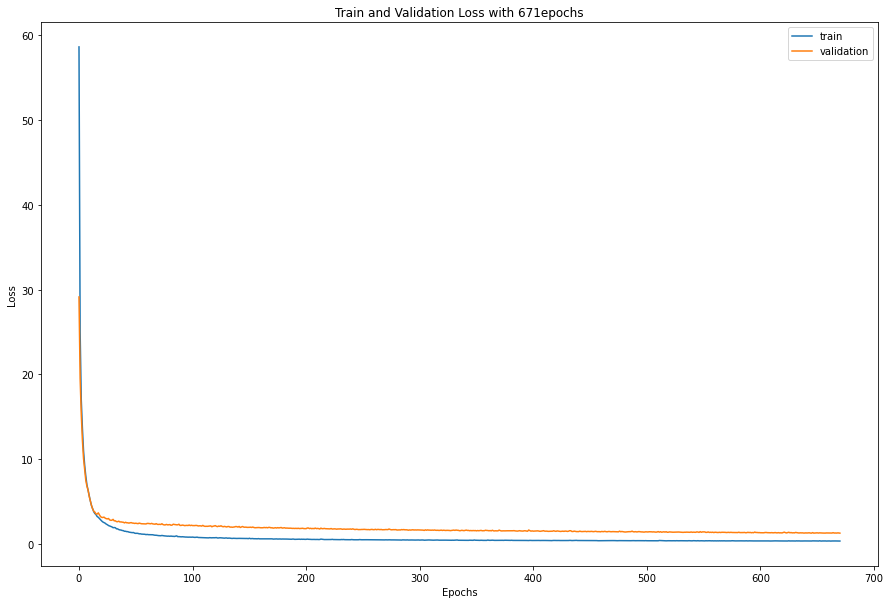

In [21]:
patience=25
# plotting training and validation history
plt.figure(figsize=(15,10))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 


plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 

plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [22]:
predictions.shape

(400, 82)

In [23]:
predict1=np.zeros(82) 
predict1=predictions[-3]
    
predict2=np.zeros((82))
predict2=predictions[-2]
    
predict3=np.zeros((82))
predict3=predictions[-1]

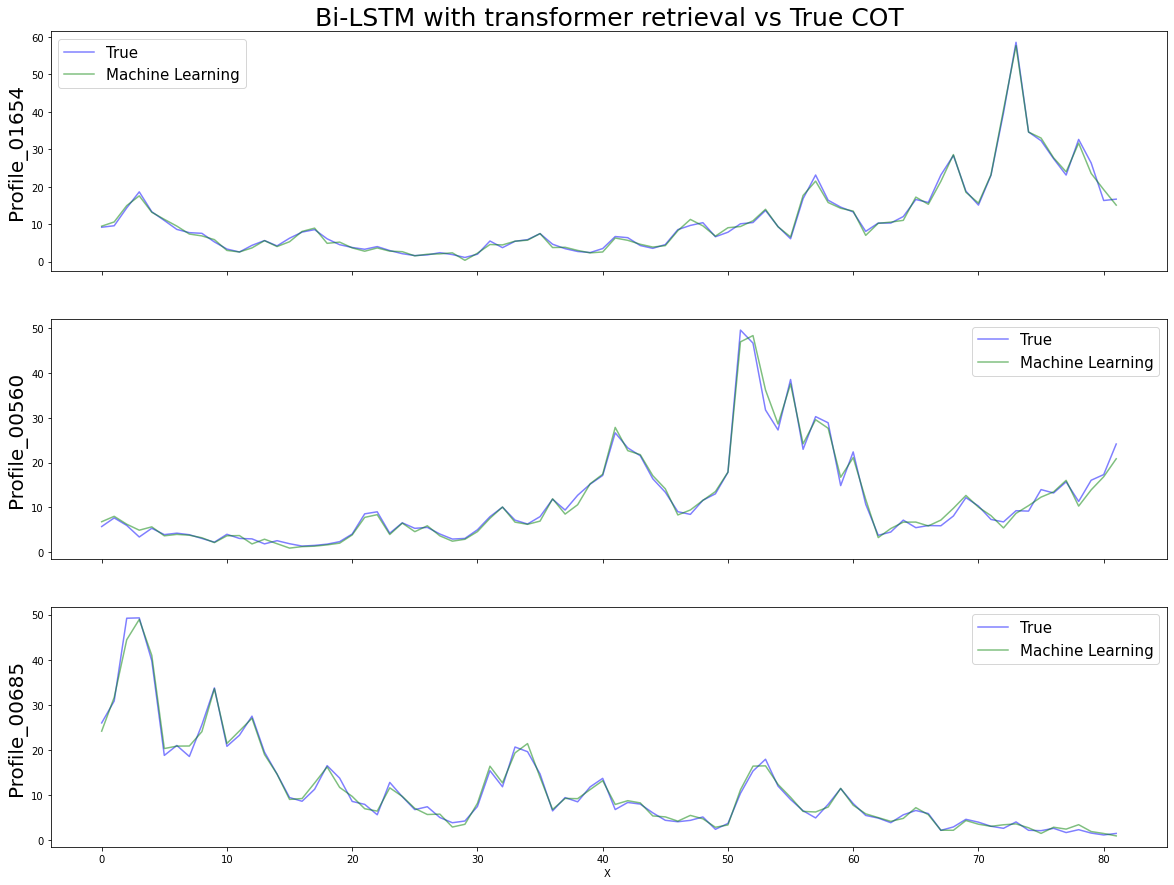

In [27]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict_Bi-LSTM with Transformer SZA=60 VZA=0_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with transformer retrieval vs True COT",fontsize=25)
ax.plot(range(82),c[num-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "Machine Learning",'1D retrieval'],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "Machine Learning",'1D retrieval'],fontsize=15)
ax.set_ylabel(r"Profile_00560",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1],alpha=0.5,color="blue")
ax.plot(range(82),predict3.reshape(82,),alpha=0.5,color="green")
ax.legend(["True", "Machine Learning",'1D retrieval'],fontsize=15)
ax.set_ylabel(r"Profile_00685",fontsize=20)  
ax.set_xlabel('X ')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')



# Plotting across predicted 82 COT values

In [34]:
std=[]
mean=[]

for k in range(82):
    tmp=[]
    for j in range(400):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))
    std.append(np.std(tmp))
    mean.append(np.mean(tmp))

std=np.array(std)
mean=np.array(mean)

std1 = np.std(mean) #standard deviation of the mean absolute difference across the 82 cot values 


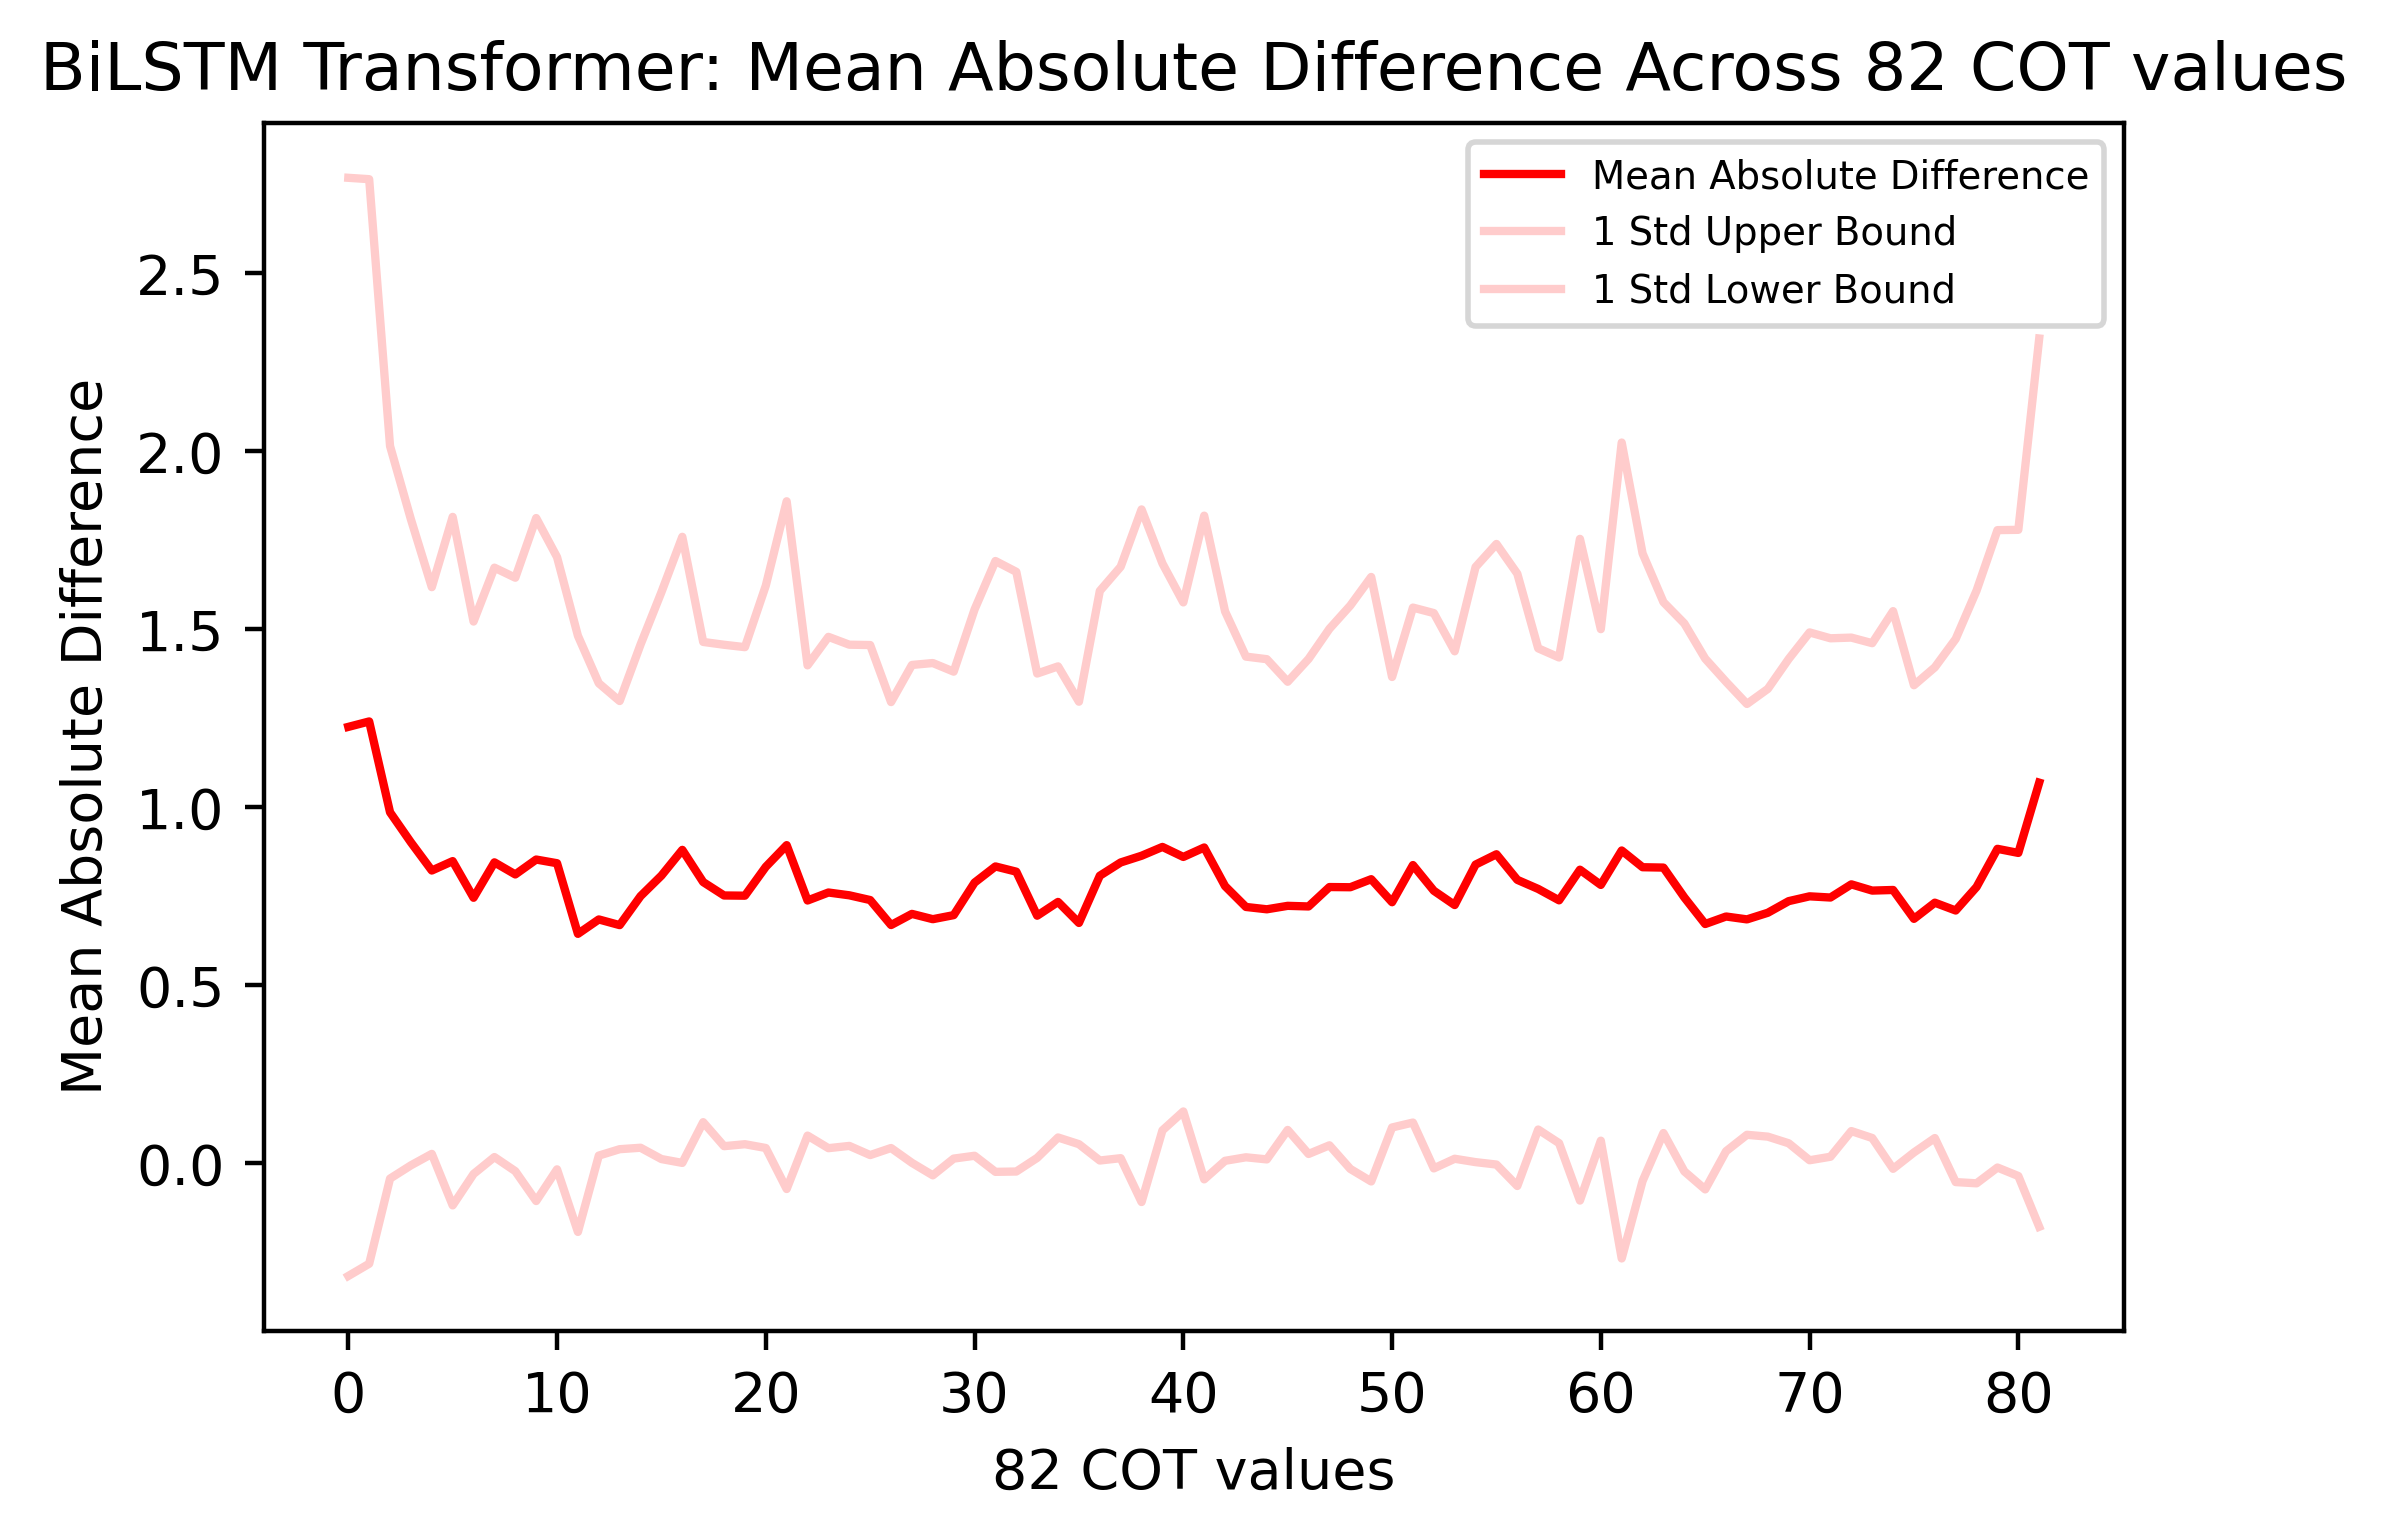

In [37]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM-transformer_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

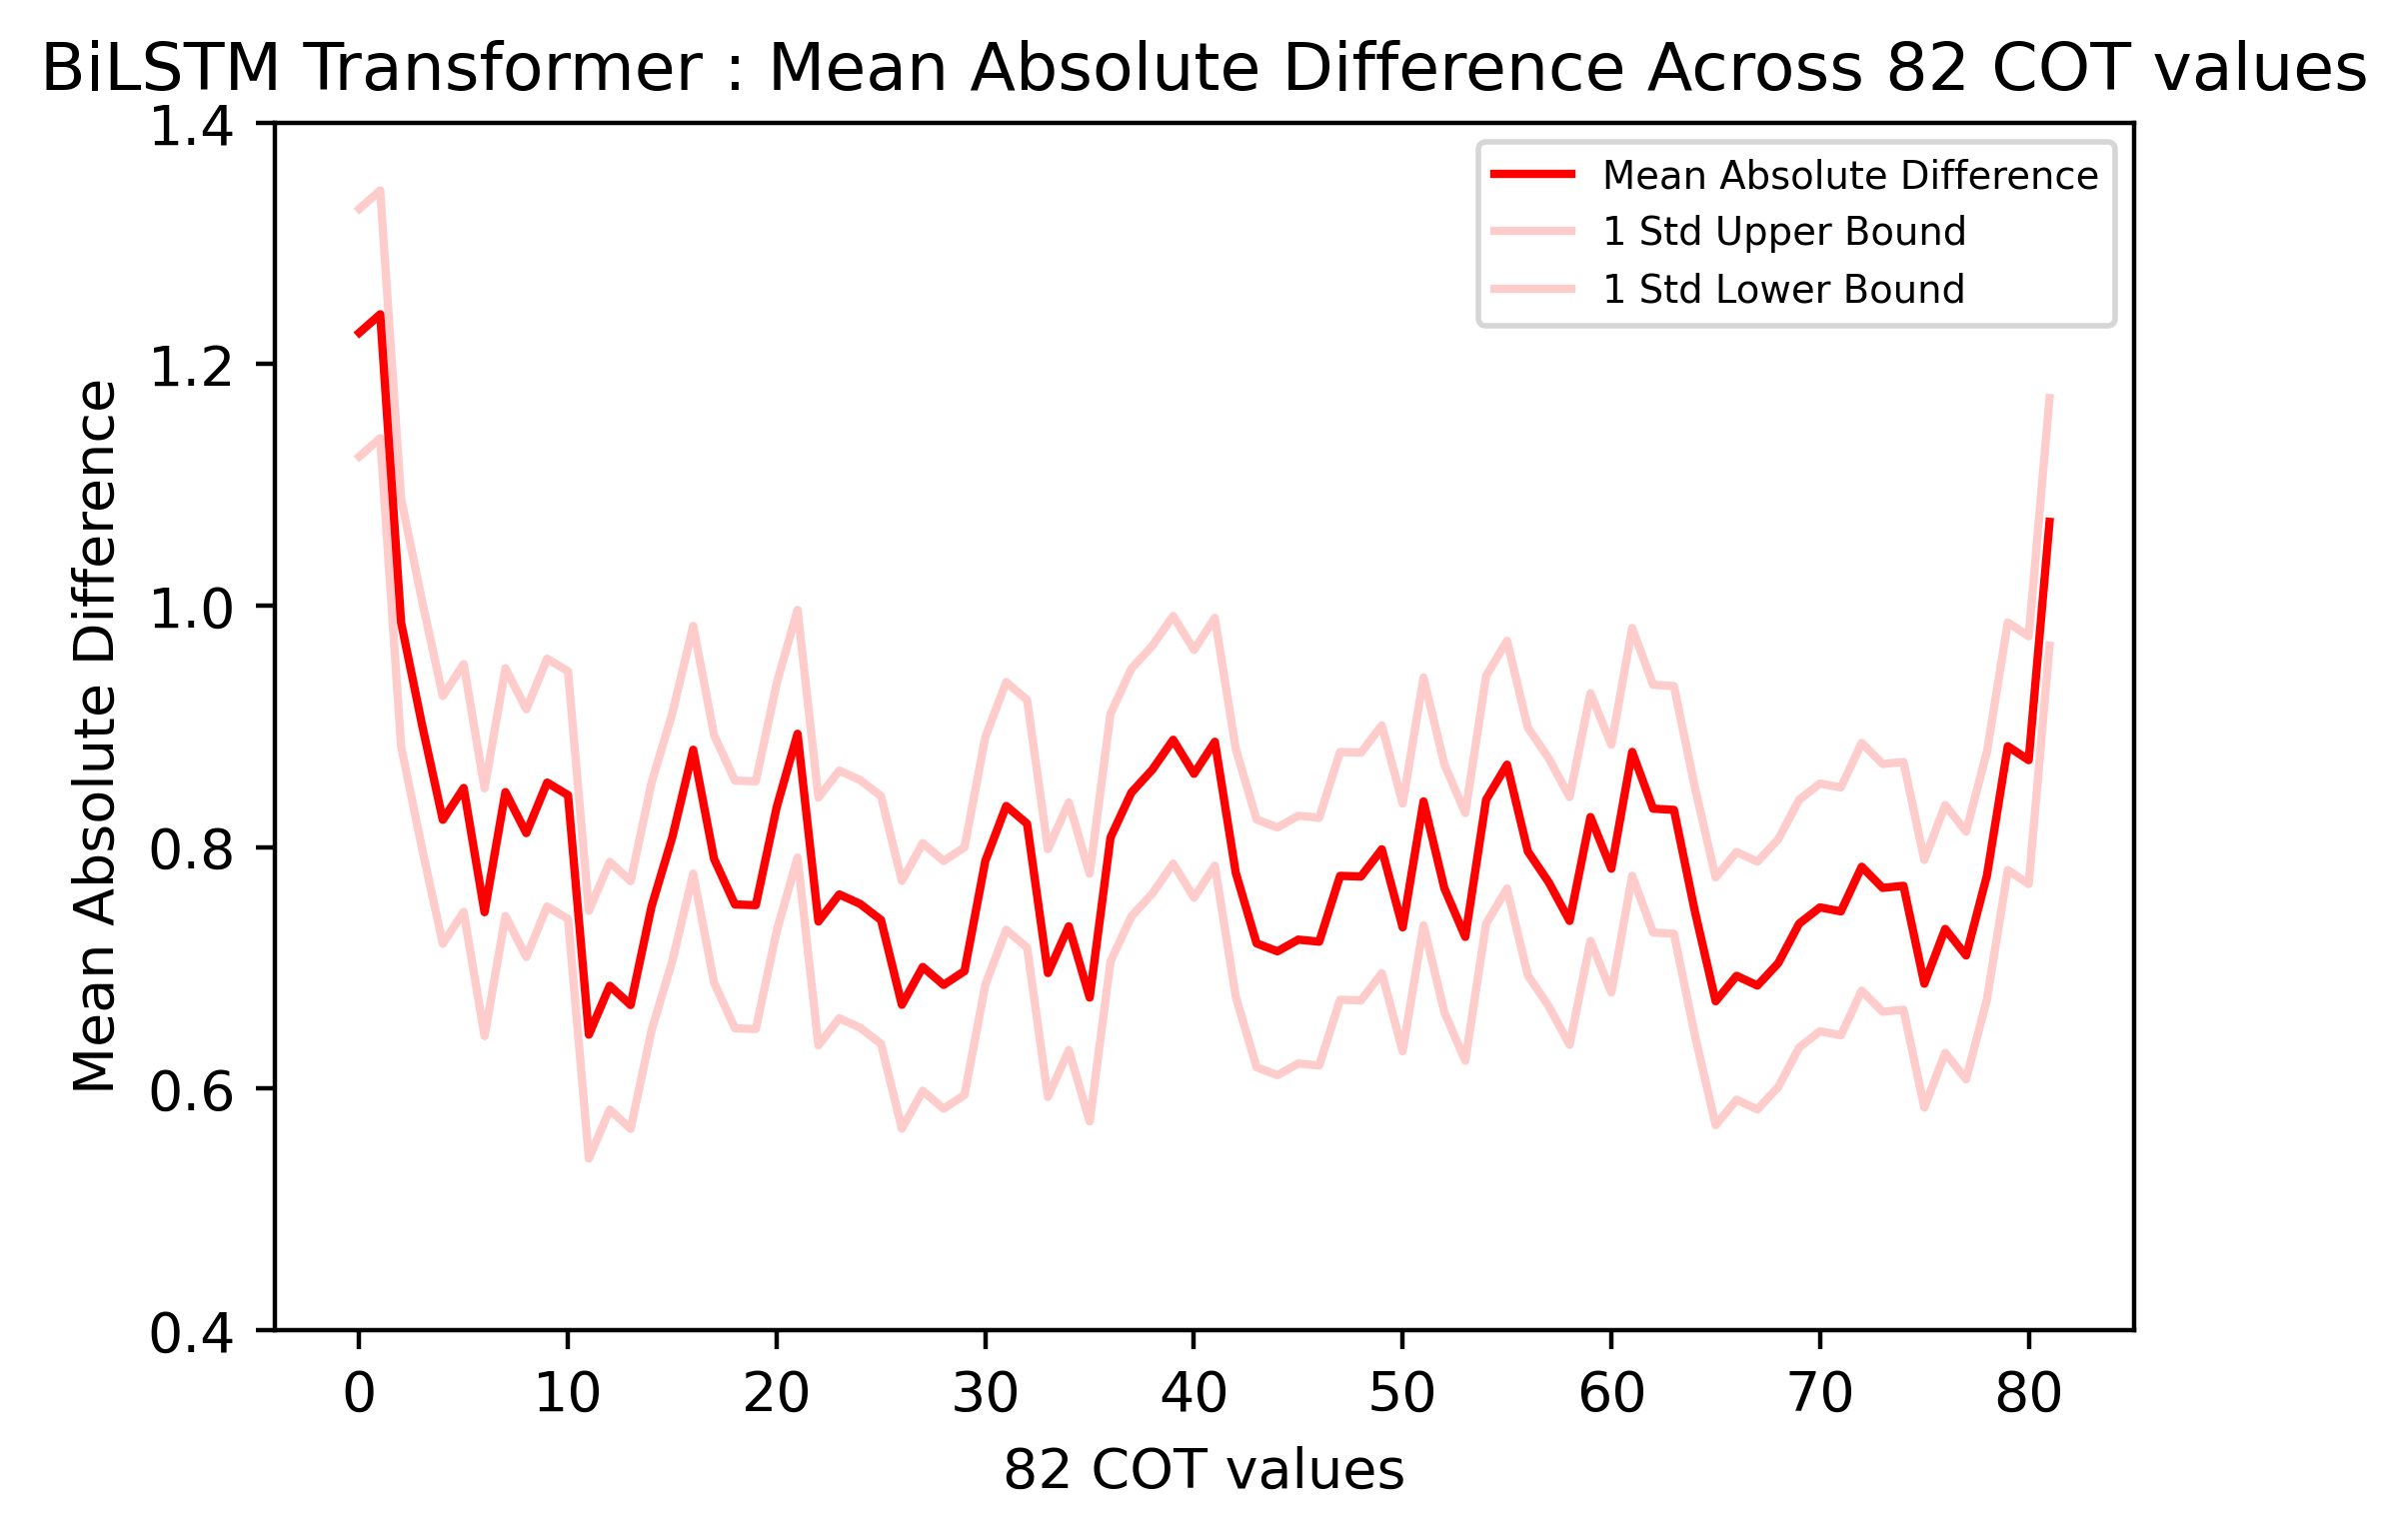

In [36]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std1, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std1, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylim((0.4,1.4))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Transformer : Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM_with_transformer_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)